In [ ]:
%pip install synthcity[all]
%pip install catenets
%pip install captum
%pip install diffprivlib
%pip install opacus

In [2]:
from synthcity.plugins import Plugins
from synthcity.metrics.eval_statistical import AlphaPrecision, InverseKLDivergence, MaximumMeanDiscrepancy, WassersteinDistance
from synthcity.metrics.eval_privacy import *
from synthcity.plugins.core.dataloader import GenericDataLoader
from synthcity.utils.serialization import save_to_file, load_from_file
import matplotlib.pyplot as plt
import pandas as pd
from catenets.models.torch import *
from catenets.experiment_utils.simulation_utils import simulate_treatment_setup
import numpy as np
from sklearn.metrics import mean_squared_error
from os import listdir
from sklearn.preprocessing import OneHotEncoder
from captum.attr import *
import torch
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import multivariate_normal
import itertools
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from synthcity.plugins.core.constraints import Constraints
import random
from OneClass import OneClassLayer
from diffprivlib.models import LogisticRegression as LogisticRegressionDP
from diffprivlib.models import RandomForestClassifier as RandomForestClassifierDP
from opacus import PrivacyEngine
from CATENets_dp.catenets_dp.models.torch import TLearner as TLearnerDP
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import sklearn.metrics
from xgboost import XGBClassifier


[KeOps] Warning : There were warnings or errors :
<stdin>:1:10: fatal error: cuda.h: No such file or directory
compilation terminated.

[KeOps] Warning : 
    The location of Cuda header files cuda.h and nvrtc.h could not be detected on your system.
    You must determine their location and then define the environment variable CUDA_PATH,
    either before launching Python or using os.environ before importing keops. For example
    if these files are in /vol/cuda/10.2.89-cudnn7.6.4.38/include you can do :
      import os
      os.environ['CUDA_PATH'] = '/vol/cuda/10.2.89-cudnn7.6.4.38'
    
[KeOps] Compiling cuda jit compiler engine ... 
[KeOps] Warning : There were warnings or errors :
/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/keopscore/binders/nvrtc/nvrtc_jit.cpp:16:10: fatal error: cuda.h: No such file or directory
 #include <cuda.h>
          ^~~~~~~~
compilation terminated.

OK
[pyKeOps] Compiling nvrtc binder for python ... 
[KeOps] Warning : There were warn

In [3]:
def encode(real):
    encoder = OneHotEncoder()
    categorical = ['x_2', 'x_21', 'x_24']
    encoded = encoder.fit_transform(real[categorical])
    encoded_df = pd.DataFrame(encoded.toarray(), columns=encoder.get_feature_names_out(categorical))
    real_encoded = pd.concat([real, encoded_df], axis=1)
    real_encoded.drop(categorical, axis=1, inplace=True)
    return real_encoded

In [4]:
def evaluate_f(real, synth, treatment_col, outcome_col):
    alpha = AlphaPrecision(random_state = random.randint(0, 1000000))

    real_cov = real.drop([treatment_col, outcome_col], axis=1)
    synth_cov = synth.drop([treatment_col, outcome_col], axis=1)

    f = alpha.evaluate(GenericDataLoader(real_cov), GenericDataLoader(synth_cov))['delta_precision_alpha_OC']

    return f

In [5]:
def evaluate_c(real, synth, treatment_col, outcome_col):
    alpha = AlphaPrecision(random_state = random.randint(0, 1000000))

    real_cov = real.drop([treatment_col, outcome_col], axis=1)
    synth_cov = synth.drop([treatment_col, outcome_col], axis=1)

    c = alpha.evaluate(GenericDataLoader(real_cov), GenericDataLoader(synth_cov))['delta_coverage_beta_OC']

    return c

In [6]:
def propensity_distance(p_real, p_synth):
    return 1 - abs(p_synth - p_real) / max(p_real, 1-p_real)

In [7]:
def train_propensity_function(real, treatment_col, outcome_col, clf, avg=False):
    X = np.array(real.drop([treatment_col, outcome_col], axis=1))
    y = np.array(real[treatment_col])
    
    if not avg:
        clf.fit(X, y)
        return clf
    
    trained_clfs = []
    for i in clf:
        i.fit(X,y)
        trained_clfs.append(i)
    
    return trained_clfs

In [8]:
def get_d_max(props):
    propensities_max = [0 if i >= 0.5 else 1 for i in props]

    return mean_squared_error(props, propensities_max, squared=False)

In [9]:
def evaluate_d(real, synth, treatment_col, outcome_col):
    n = len(real)
    n_test = 0.2*n
    test = real[:round(n_test)]
    real = real[round(n_test):]

    pi_real = LogisticRegression()
    pi_synth = LogisticRegression()
    pi_real = train_propensity_function(real, treatment_col, outcome_col, pi_real)
    pi_synth = train_propensity_function(synth, treatment_col, outcome_col, pi_synth)

    probabilities_real = pi_real.predict_proba(np.array(test.drop([treatment_col, outcome_col], axis=1)))
    propensities_real = probabilities_real[:, 1]

    probabilities_synth = pi_synth.predict_proba(np.array(test.drop([treatment_col, outcome_col], axis=1)))
    propensities_synth = probabilities_synth[:, 1]

    d_max = get_d_max(propensities_real)

    return 1 - mean_squared_error(propensities_real, propensities_synth, squared=False)/d_max

In [10]:
def evaluate_average_d(real, synth, treatment_col, outcome_col):
    real_learners = [LogisticRegression(), RandomForestClassifier(random_state=0), XGBClassifier(random_state=0)]
    synth_learners = [LogisticRegression(), RandomForestClassifier(random_state=0), XGBClassifier(random_state=0)]
    n = len(real)
    n_test = 0.2*n
    test = real[:round(n_test)]
    #real = real[round(n_test):]

    real_learners = train_propensity_function(real, treatment_col, outcome_col, real_learners, avg=True)
    synth_learners = train_propensity_function(synth, treatment_col, outcome_col, synth_learners, avg=True)

    avg_d = 0

    for i in range(len(real_learners)):
        pi_real = real_learners[i]
        pi_synth = synth_learners[i]
        probabilities_real = pi_real.predict_proba(np.array(test.drop([treatment_col, outcome_col], axis=1)))
        propensities_real = probabilities_real[:, 1]
        probabilities_synth = pi_synth.predict_proba(np.array(test.drop([treatment_col, outcome_col], axis=1)))
        propensities_synth = probabilities_synth[:, 1]
        d_max = get_d_max(propensities_real)

        d = 1 - mean_squared_error(propensities_real, propensities_synth, squared=False)/d_max
        print(d)
        avg_d += d

    return avg_d / len(real_learners)
    

In [11]:
def cosine_average_first(v1, v2):
    return cosine_similarity(v1.sum(axis=0).reshape(1,-1), v2.sum(axis=0).reshape(1,-1))[0][0]

In [12]:
def evaluate_u_int(real, synth, treatment_col, outcome_col, n_units, binary_y=False):
    n = len(real)
    n_test = 0.2*n
    test = real[:round(n_test)]
    real = real[round(n_test):]


    l_real = TLearner(n_unit_in=n_units, binary_y=binary_y, seed=random.randint(0,1000000))
    X_real = np.array(real.drop([treatment_col, outcome_col], axis=1))
    y_real = np.array(real[outcome_col])
    w_real = np.array(real[treatment_col])
    l_real.fit(X_real, y_real, w_real)
    ig_real = IntegratedGradients(l_real)
    X_t = np.array(test.drop([treatment_col, outcome_col], axis=1))
    X_t = torch.tensor(X_t)
    attr_real = ig_real.attribute(X_t)

    l_synth = TLearner(n_unit_in=n_units, binary_y=binary_y, seed=random.randint(0,1000000))
    X_synth = np.array(synth.drop([treatment_col, outcome_col], axis=1))
    y_synth = np.array(synth[outcome_col])
    w_synth = np.array(synth[treatment_col])
    l_synth.fit(X_synth, y_synth, w_synth)
    ig_synth = IntegratedGradients(l_synth)
    attr_synth = ig_synth.attribute(X_t)

    first = cosine_average_first(attr_real, attr_synth)
    return first

In [13]:
def evaluate_u_pehe(real, synth, treatment_col, outcome_col, n_units, binary_y = False):
    n = len(real)
    n_test = 0.2*n
    test = real[:round(n_test)]
    real = real[round(n_test):]

    l_real = TLearner(n_unit_in=n_units, binary_y=binary_y, seed=random.randint(0,1000000))
    X_real = np.array(real.drop([treatment_col, outcome_col], axis=1))
    y_real = np.array(real[outcome_col])
    w_real = np.array(real[treatment_col])
    l_real.fit(X_real, y_real, w_real)
    X_t = np.array(test.drop([treatment_col, outcome_col], axis=1))
    X_t = torch.tensor(X_t)
    pred_real = l_real.predict(X_t)

    l_synth = TLearner(n_unit_in=n_units, binary_y=binary_y, seed=random.randint(0,1000000))
    X_synth = np.array(synth.drop([treatment_col, outcome_col], axis=1))
    y_synth = np.array(synth[outcome_col])
    w_synth = np.array(synth[treatment_col])
    l_synth.fit(X_synth, y_synth, w_synth)
    pred_synth = l_synth.predict(X_t)

    pehe = mean_squared_error(pred_real.cpu().detach().numpy(), pred_synth.cpu().detach().numpy(), squared=False)
    return pehe

In [14]:
def evaluate_average_u_pehe(real, synth, treatment_col, outcome_col, n_units, binary_y = False):
    n = len(real)
    n_test = 0.2*n
    test = real[:round(n_test)]
    real = real[round(n_test):]

    real_learners = [TLearner(n_unit_in=n_units, binary_y=binary_y, seed=random.randint(0,1000000)), SLearner(n_unit_in=n_units, binary_y=binary_y, seed=random.randint(0,1000000)), 
                DRLearner(n_unit_in=n_units, binary_y=binary_y, seed=random.randint(0,1000000)), RALearner(n_unit_in=n_units, binary_y=binary_y,seed=random.randint(0,1000000))]
    synth_learners = [TLearner(n_unit_in=n_units, binary_y=binary_y, seed=random.randint(0,1000000)), SLearner(n_unit_in=n_units, binary_y=binary_y, seed=random.randint(0,1000000)), 
                DRLearner(n_unit_in=n_units, binary_y=binary_y, seed=random.randint(0,1000000)), RALearner(n_unit_in=n_units, binary_y=binary_y,seed=random.randint(0,1000000))]

    avg_pehe = 0
    for i in range(len(real_learners)):
        l_real = real_learners[i]
        l_synth = synth_learners[i]
        X_real = np.array(real.drop([treatment_col, outcome_col], axis=1))
        y_real = np.array(real[outcome_col])
        w_real = np.array(real[treatment_col])
        l_real.fit(X_real, y_real, w_real)
        X_t = np.array(test.drop([treatment_col, outcome_col], axis=1))
        X_t = torch.tensor(X_t)
        pred_real = l_real.predict(X_t)

        X_synth = np.array(synth.drop([treatment_col, outcome_col], axis=1))
        y_synth = np.array(synth[outcome_col])
        w_synth = np.array(synth[treatment_col])
        l_synth.fit(X_synth, y_synth, w_synth)
        pred_synth = l_synth.predict(X_t)

        pehe = mean_squared_error(pred_real.cpu().detach().numpy(), pred_synth.cpu().detach().numpy(), squared=False)
        avg_pehe += pehe

    return avg_pehe / len(real_learners)

In [15]:
def evaluate_u_policy(real, synth, treatment_col, outcome_col, n_units, binary_y = False):
    n = len(real)
    n_test = 0.2*n
    test = real[:round(n_test)]
    real = real[round(n_test):]

    l_real = TLearner(n_unit_in=n_units, binary_y=binary_y, seed=random.randint(0,1000000))
    X_real = np.array(real.drop([treatment_col, outcome_col], axis=1))
    y_real = np.array(real[outcome_col])
    w_real = np.array(real[treatment_col])
    l_real.fit(X_real, y_real, w_real)
    X_t = np.array(test.drop([treatment_col, outcome_col], axis=1))
    X_t = torch.tensor(X_t)
    pred_real = l_real.predict(X_t)

    l_synth = TLearner(n_unit_in=n_units, binary_y=binary_y, seed=random.randint(0,1000000))
    X_synth = np.array(synth.drop([treatment_col, outcome_col], axis=1))
    y_synth = np.array(synth[outcome_col])
    w_synth = np.array(synth[treatment_col])
    l_synth.fit(X_synth, y_synth, w_synth)
    pred_synth = l_synth.predict(X_t)

    pred_mult = pd.DataFrame(pred_real * pred_synth)
    num_pos = len(pred_mult[pred_mult[0]>0])
    correct_rate = num_pos / len(pred_real)

    return correct_rate

In [16]:
def evaluate_average_u_policy(real, synth, treatment_col, outcome_col, n_units):
    n = len(real)
    n_test = 0.2*n
    test = real[:round(n_test)]
    real = real[round(n_test):]

    real_learners = [TLearner(n_unit_in=n_units, binary_y=False, seed=random.randint(0,1000000)), SLearner(n_unit_in=n_units, binary_y=False, seed=random.randint(0,1000000)), 
                DRLearner(n_unit_in=n_units, binary_y=False, seed=random.randint(0,1000000)), RALearner(n_unit_in=n_units, binary_y=False,seed=random.randint(0,1000000))]
    synth_learners = [TLearner(n_unit_in=n_units, binary_y=False, seed=random.randint(0,1000000)), SLearner(n_unit_in=n_units, binary_y=False, seed=random.randint(0,1000000)), 
                DRLearner(n_unit_in=n_units, binary_y=False, seed=random.randint(0,1000000)), RALearner(n_unit_in=n_units, binary_y=False,seed=random.randint(0,1000000))]

    avg_correct_rate = 0
    for i in range(len(real_learners)):
        l_real = real_learners[i]
        l_synth = synth_learners[i]
        X_real = np.array(real.drop([treatment_col, outcome_col], axis=1))
        y_real = np.array(real[outcome_col])
        w_real = np.array(real[treatment_col])
        l_real.fit(X_real, y_real, w_real)
        X_t = np.array(test.drop([treatment_col, outcome_col], axis=1))
        X_t = torch.tensor(X_t)
        pred_real = l_real.predict(X_t)

        X_synth = np.array(synth.drop([treatment_col, outcome_col], axis=1))
        y_synth = np.array(synth[outcome_col])
        w_synth = np.array(synth[treatment_col])
        l_synth.fit(X_synth, y_synth, w_synth)
        pred_synth = l_synth.predict(X_t)

        pred_mult = pd.DataFrame(pred_real * pred_synth)
        num_pos = len(pred_mult[pred_mult[0]>0])
        correct_rate = num_pos / len(pred_real)
        avg_correct_rate += correct_rate
        #print(f'{l_synth.__str__()} PEHE: {pehe}')

    return avg_correct_rate / len(real_learners)

In [17]:
def generate_sequentially_to_w(real, gen, treatment_col, outcome_col, encode=False, private=False, epsilon=None, delta=None):
    random.seed()

    #generate covariates
    if private:
        g = Plugins().get(gen, random_state = random.randint(0, 1000000), epsilon=epsilon, delta=delta)
    else:
        g = Plugins().get(gen, random_state = random.randint(0, 1000000))
    real_cov = real.drop([treatment_col, outcome_col], axis=1)
    print(f'Fitting {gen} covariate model')
    g.fit(real_cov)
    print(f'Generating {gen} synthetic covariates')
    synth_cov = g.generate(count = len(real)).dataframe()

    if encode:
        real_encoded, syn_encoded = encode_acic(real, synth_cov)
    else:
        real_encoded, syn_encoded = real, synth_cov

    #generate propensities
    X = np.array(real_encoded.drop([treatment_col, outcome_col], axis=1))
    y = np.array(real_encoded[treatment_col])
    
    if private:
        classifier = LogisticRegressionDP(random_state = random.randint(0, 1000000), epsilon=epsilon)
    else:
        classifier = LogisticRegression(random_state = random.randint(0, 1000000))
    print('Fitting propensity model')
    classifier.fit(X, y)
    print('Generating propensities')
    probabilities = classifier.predict_proba(np.array(syn_encoded))
    prob_class_1 = probabilities[:, 1]
    binary_outcomes = np.random.binomial(n=1, p=prob_class_1)

    synth_cov_with_prop = syn_encoded
    synth_cov_with_prop[treatment_col] = pd.Series(binary_outcomes)

    synth_cov_with_prop[outcome_col] = 0

    return synth_cov_with_prop

In [18]:
def generate_sequentially(real, gen, treatment_col, outcome_col, encode=False, private=False, epsilon=None, delta=None, binary_y=False):
    random.seed()
    synth = generate_sequentially_to_w(real, gen, treatment_col, outcome_col, encode=encode, private=private, epsilon=epsilon, delta=delta)

    X = np.array(real.drop([treatment_col, outcome_col], axis=1))
    y = np.array(real[outcome_col])
    w = np.array(real[treatment_col])
    n_units = len(real.drop([treatment_col, outcome_col], axis=1).columns)
    if private:
        l = TLearnerDP(n_unit_in=n_units, binary_y=binary_y, seed=random.randint(0,1000000), batch_norm=False)
        print('Fitting private CATE learner')
        l.fit(X, y, w, epsilon=epsilon, delta=delta)
    else:
        l = TLearner(n_unit_in=n_units, binary_y=binary_y, seed=random.randint(0,1000000), batch_norm=False)
        print('Fitting CATE learner')
        l.fit(X, y, w)

    seq_X = np.array(synth.drop([treatment_col, outcome_col], axis=1))
    print('Generating POs')
    cate, y0, y1 = l.predict(seq_X, return_po=True)

    outcomes = []
    for index, value in synth[treatment_col].iteritems():
        if value == 0:
            outcomes.append(y0[index].item())
        else:
            outcomes.append(y1[index].item())

    synth[outcome_col] = outcomes
    return synth

In [19]:
def generate_standard(real, gen, private=False, epsilon=None, delta=None):
    random.seed()
    if private:
        g = Plugins().get(gen, random_state = random.randint(0, 1000000), epsilon=epsilon, delta=delta)
    else:
        g = Plugins().get(gen, random_state = random.randint(0, 1000000))
    print(f'Fitting {gen} model')
    g.fit(real)
    print(f'Generating {gen} synthetic dataset')
    synth = g.generate(count = len(real)).dataframe()
    return synth

In [20]:
def seq_test(real, gen, treatment_col, outcome_col, n_iter, encode=False, private=False, epsilon=None, delta=None, binary_y=False, save=False, fp=''):
    results = pd.DataFrame(columns = ['method', 'f', 'c', 'd', 'u_pehe', 'u_policy', 'u_int'])
    for _ in range(n_iter):
        stand = generate_standard(real, gen, private=private, epsilon=epsilon, delta=delta)
        seq_new = generate_sequentially(real, gen, treatment_col, outcome_col, encode=encode, private=private, epsilon=epsilon, delta=delta,binary_y=binary_y)
        n_units = len(real.drop([treatment_col, outcome_col], axis=1).columns)
        
        if encode:
            real_encoded, stand_encoded = encode_acic(real, stand)
            _, seq_encoded = encode_acic(real, seq_new)
        else:
            real_encoded = real
            stand_encoded = stand
            seq_encoded = seq_new

        results.loc[len(results)] = ['standard', evaluate_f(real_encoded, stand_encoded, treatment_col, outcome_col), evaluate_c(real_encoded, stand_encoded, treatment_col, outcome_col), 
                                     evaluate_d(real_encoded, stand_encoded, treatment_col, outcome_col), evaluate_average_u_pehe(real_encoded, stand_encoded, treatment_col, outcome_col, n_units,binary_y), 
                                     evaluate_u_policy(real_encoded, stand_encoded, treatment_col, outcome_col, n_units,binary_y), evaluate_u_int(real_encoded, stand_encoded, treatment_col, outcome_col, n_units,binary_y)]
        results.loc[len(results)] = ['seq_new', evaluate_f(real_encoded, seq_encoded, treatment_col, outcome_col), evaluate_c(real_encoded, seq_encoded, treatment_col, outcome_col), 
                                     evaluate_d(real_encoded, seq_encoded, treatment_col, outcome_col), evaluate_average_u_pehe(real_encoded, seq_encoded, treatment_col, outcome_col, n_units,binary_y), 
                                     evaluate_u_policy(real_encoded, seq_encoded, treatment_col, outcome_col, n_units,binary_y), evaluate_u_int(real_encoded, seq_encoded, treatment_col, outcome_col, n_units,binary_y)]
        if save:
            results.to_csv(fp, index=False)
    
    return results


# Load real datasets

In [58]:
ihdp_full = pd.read_csv('../Datasets/ihdp.csv')
ihdp = ihdp_full.drop(['y_cfactual', 'mu0', 'mu1'], axis=1)
ihdp['treatment'] = ihdp['treatment'].astype(int)
#train on 80% of the data, the remaining 20% for testing of CATE estimators
train_ihdp = ihdp.loc[[i for i in range(600)]]
test_ihdp = ihdp.loc[[i+600 for i in range(147)]]

In [22]:
jobs =pd.read_csv('../Datasets/jobs_small.csv')

In [35]:
twins = pd.read_csv('../Datasets/twins.csv')
twins = twins.dropna()
twins = twins.drop(['infant_id'], axis=1)

In [22]:
acic_full = pd.read_csv('../Datasets/acic.csv')
acic_full['y'] = acic_full['y0']
acic_full.loc[acic_full['z']==1, 'y'] = acic_full.loc[acic_full['z']==1, 'y1']

acic = acic_full.drop(['y0', 'y1', 'mu0', 'mu1'], axis=1)
acic_train = acic.loc[[i for i in range(4000)]]
acic_test = acic.loc[[i+4000 for i in range(802)]]
acic_encoded = encode(acic)

In [41]:
twins.dropna()

,pldel,birattnd,brstate,stoccfipb,mager8,ormoth,mrace,meduc6,dmar,mplbir,...,feduc6,dlivord_min,dtotord_min,bord,brstate_reg,stoccfipb_reg,mplbir_reg,wt,treatment,outcome
0,1.0,1.0,1.0,1.0,3.0,0.0,1.0,3.0,1.0,1.0,...,3.0,3.0,3.0,2.0,5.0,5.0,5.0,936.0,0,0.0
1,1.0,1.0,1.0,1.0,3.0,0.0,1.0,3.0,1.0,1.0,...,3.0,3.0,3.0,1.0,5.0,5.0,5.0,1006.0,1,0.0
6,1.0,1.0,1.0,1.0,6.0,0.0,1.0,5.0,1.0,1.0,...,5.0,2.0,2.0,2.0,5.0,5.0,5.0,1030.0,0,0.0
7,1.0,1.0,1.0,1.0,6.0,0.0,1.0,5.0,1.0,1.0,...,5.0,2.0,2.0,1.0,5.0,5.0,5.0,1070.0,1,0.0
8,1.0,1.0,1.0,1.0,5.0,0.0,2.0,3.0,1.0,1.0,...,5.0,3.0,3.0,2.0,5.0,5.0,5.0,901.0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23963,1.0,1.0,50.0,55.0,3.0,0.0,1.0,3.0,1.0,50.0,...,3.0,1.0,2.0,2.0,2.0,2.0,2.0,1758.0,1,0.0
23964,1.0,1.0,50.0,55.0,6.0,0.0,1.0,5.0,1.0,5.0,...,4.0,3.0,3.0,1.0,2.0,2.0,8.0,1616.0,0,0.0
23965,1.0,1.0,50.0,55.0,6.0,0.0,1.0,5.0,1.0,5.0,...,4.0,3.0,3.0,2.0,2.0,2.0,8.0,1814.0,1,0.0
23966,1.0,2.0,51.0,56.0,4.0,0.0,1.0,4.0,1.0,17.0,...,3.0,1.0,1.0,1.0,7.0,7.0,3.0,936.0,0,1.0


In [38]:
evaluate_f(twins, twins, 'treatment', 'outcome')

0.9999310964720917

In [39]:
evaluate_d(twins, twins, 'treatment', 'outcome')

0.989109673739197

In [52]:
evaluate_u_pehe(twins, twins, 'treatment', 'outcome', 50, binary_y=True)

0.08014811

# Illustrative metric failure section

### Faiure to model $P_X$

In [225]:
X, y, w, p, t = simulate_treatment_setup(1000, 2)
X_df = pd.DataFrame(X)
y_df = pd.DataFrame(y, columns = ['y'])
w_df = pd.DataFrame(w, columns = ['w'])

d_real = pd.concat([X_df,w_df,y_df], axis=1)
c = d_real.drop(['w', 'y'], axis=1).columns

In [226]:
X, y, w, p, t = simulate_treatment_setup(1000, 2,seed=1)
X_df = pd.DataFrame(X)
y_df = pd.DataFrame(y, columns = ['y'])
w_df = pd.DataFrame(w, columns = ['w'])

d_syn = pd.concat([X_df,w_df,y_df], axis=1)
d_syn[c] = 0

In [197]:
#d_syn = d_real.copy()
#poor
#d_syn[c] = 0

#good
#d_syn['y'] = np.random.normal(loc = 0, size=(1000,1))
#d_syn['w'] = np.random.choice(2, size=1000, p=[0.5,0.5])

In [227]:
alpha = AlphaPrecision()
kl = InverseKLDivergence()
mmd = MaximumMeanDiscrepancy()

In [228]:
alpha.evaluate(GenericDataLoader(d_real), GenericDataLoader(d_syn))

{'delta_precision_alpha_OC': 0.8127103448275862,
 'delta_coverage_beta_OC': 0.28733333333333333,
 'authenticity_OC': 0.676,
 'delta_precision_alpha_naive': 0.10006666666666664,
 'delta_coverage_beta_naive': 0.004733333333333478,
 'authenticity_naive': 0.996}

In [229]:
kl.evaluate(GenericDataLoader(d_real), GenericDataLoader(d_syn))

{'marginal': 0.5257114265999299}

In [230]:
mmd.evaluate(GenericDataLoader(d_real), GenericDataLoader(d_syn))

{'joint': 0.16753760670809048}

### Failure to model $P_{W|X}$

In [219]:
X, y, w, p, t = simulate_treatment_setup(1000, 2)
X_df = pd.DataFrame(X)
y_df = pd.DataFrame(y, columns = ['y'])
w_df = pd.DataFrame(w, columns = ['w'])

d_real = pd.concat([X_df,w_df,y_df], axis=1)
#d_real[c] *= 10

In [220]:
X, y, w, p, t = simulate_treatment_setup(1000, 2, seed=1)
X_df = pd.DataFrame(X)
y_df = pd.DataFrame(y, columns = ['y'])
w_df = pd.DataFrame(w, columns = ['w'])

d_syn = pd.concat([X_df,w_df,y_df], axis=1)
d_syn['w'] = 0

In [120]:
#d_syn = d_real.copy()
#poor
#d_syn['w'] = 0

#good
#d_syn['y'] = np.random.normal(loc = 0, size=(1000,1))
#d_syn[[0,1]] = np.random.normal(loc = 0, size=(1000,2))

In [221]:
alpha = AlphaPrecision()
kl = InverseKLDivergence()
mmd = MaximumMeanDiscrepancy()

In [222]:
alpha.evaluate(GenericDataLoader(d_real), GenericDataLoader(d_syn))

{'delta_precision_alpha_OC': 0.5074666666666666,
 'delta_coverage_beta_OC': 0.29679999999999995,
 'authenticity_OC': 0.617,
 'delta_precision_alpha_naive': 0.9239999999999999,
 'delta_coverage_beta_naive': 0.3389333333333333,
 'authenticity_naive': 0.688}

In [223]:
kl.evaluate(GenericDataLoader(d_real), GenericDataLoader(d_syn))

{'marginal': 0.76468268318991}

In [224]:
mmd.evaluate(GenericDataLoader(d_real), GenericDataLoader(d_syn))

{'joint': 0.029881637517529452}

### Failure to model $P_{Y|W,X}$

In [247]:
X, y, w, p, t = simulate_treatment_setup(1000, 2, n_t=2)
X_df = pd.DataFrame(X)
y_df = pd.DataFrame(y, columns = ['y'])
w_df = pd.DataFrame(w, columns = ['w'])

d_real = pd.concat([X_df,w_df,y_df], axis=1)
#d_real[c] *= 10

In [248]:
X, y, w, p, t = simulate_treatment_setup(1000, 2, n_t=2, seed=1)
X_df = pd.DataFrame(X)
y_df = pd.DataFrame(y, columns = ['y'])
w_df = pd.DataFrame(w, columns = ['w'])

d_syn = pd.concat([X_df,w_df,y_df], axis=1)
d_syn['y'] = np.random.normal(loc = 0, size=(1000,1))

In [249]:
#d_syn = d_real.copy()
#poor
#d_syn['y'] = np.random.normal(loc = 0, size=(1000,1))

#good
#d_syn['w'] = np.random.choice(2, size=1000, p=[0.5,0.5])
#d_syn[[0,1]] = np.random.normal(loc = 0, size=(1000,2))

In [250]:
alpha.evaluate(GenericDataLoader(d_real), GenericDataLoader(d_syn))

{'delta_precision_alpha_OC': 0.8434,
 'delta_coverage_beta_OC': 0.4132,
 'authenticity_OC': 0.521,
 'delta_precision_alpha_naive': 0.9745885057471264,
 'delta_coverage_beta_naive': 0.5036666666666667,
 'authenticity_naive': 0.489}

In [251]:
kl.evaluate(GenericDataLoader(d_real), GenericDataLoader(d_syn))

{'marginal': 0.8235761532298621}

In [252]:
mmd.evaluate(GenericDataLoader(d_real), GenericDataLoader(d_syn))

{'joint': 0.007128943324623382}

## Showing our metrics work

### D

In [42]:
def generate_propensities_datasets(n, correct):
    random.seed()
    X, y, w, p, t = simulate_treatment_setup(n, 20, seed=random.randint(0,1000000))
    X_df = pd.DataFrame(X)
    y_df = pd.DataFrame(y, columns = ['y'])
    w_df = pd.DataFrame(w, columns = ['w'])
    d = pd.concat([X_df,w_df,y_df], axis=1)

    X, y, w, p, t = simulate_treatment_setup(n, 20,seed=random.randint(0,1000000))
    X_df = pd.DataFrame(X)
    y_df = pd.DataFrame(y, columns = ['y'])
    w_df = pd.DataFrame(w, columns = ['w'])
    d_adv = pd.concat([X_df,w_df,y_df], axis=1)
    
    n_correct = round(correct*n)
    d_adv['w'] = 0
    d_adv.loc[:n_correct,'w'] = 1

    return d, d_adv

In [43]:
def new_metrics_propensity_exp(n, corrects, n_iter):
    results = pd.DataFrame(columns=['treated %', 'd'])
    alpha = AlphaPrecision()
    kl = InverseKLDivergence()

    for c in corrects:
        for _ in range(n_iter):
            d_real, d_adv = generate_propensities_datasets(n, c)

            d = evaluate_d(d_real,d_adv,'w','y')
            results.loc[len(results)] = [c,d]
            print('done')
    return results


In [44]:
results_prop = new_metrics_propensity_exp(10000, [0.01, 0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9, 0.99], 5)

done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done


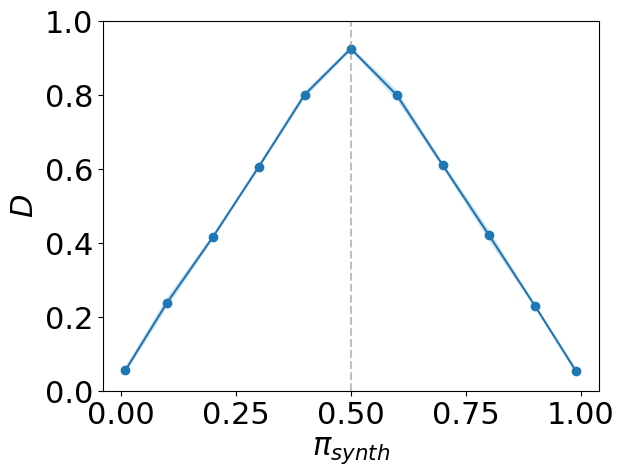

In [46]:
x = [0.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.99]
d = results_prop.groupby('treated %').mean()['d']
d_std = results_prop.groupby('treated %').std()['d'] / np.sqrt(5) * 1.96

plt.rcParams.update({'font.size': 22})
plt.plot(x, d, 'o-', label = 'd')
plt.fill_between(x, d - d_std, d + d_std, alpha=0.2)
plt.ylim([0,1])
plt.axvline(x=0.5, color='gray', linestyle='--', alpha=0.5)
plt.ylabel('$D$')
plt.xlabel('$\pi_{synth}$')

plt.savefig('plots/propensity_metric_plot.pdf', bbox_inches='tight')

### U

In [ ]:
def create_simulated_datasets(n, d, n_o, n_t, n_known, error_sd=0):
    random.seed()
    X,y,w,p,t = simulate_treatment_setup(n, d=d, n_o=n_o, n_t=n_t, error_sd=error_sd, seed=random.randint(0,1000000))
    X_df = pd.DataFrame(X)
    y_df = pd.DataFrame(y, columns = ['y'])
    w_df = pd.DataFrame(w, columns = ['w'])
    d_real = pd.concat([X_df,w_df,y_df], axis=1)

    X,y,w,p,t = simulate_treatment_setup(n, d=d, n_o=n_o, n_t=n_t, error_sd=error_sd, seed=random.randint(0,1000000))
    X_df = pd.DataFrame(X)
    w_df = pd.DataFrame(w, columns = ['w'])
    d_synth = pd.concat([X_df,w_df], axis=1)

    #mu0_coefs = np.ones(n_o)
    #mu0 = np.dot(X[:, : n_o] ** 2, mu0_coefs)
    
    mu1_coefs = np.ones(n_known)
    X_sel = X[:, n_o : n_o + n_known]
    mu1 = np.dot(X_sel**2, mu1_coefs)#+mu0

    new_column_values = []
    for index, value in d_synth['w'].iteritems():
        if value == 0:
            new_column_values.append(0+ np.random.normal(scale=error_sd))#.append(mu0[index])
        else:
            new_column_values.append(mu1[index]+ np.random.normal(scale=error_sd)) 

    d_synth['y'] = new_column_values

    return d_real, d_synth

In [ ]:
def run_utility_exp(n, d, n_o, n_t, n_knowns, n_iter, error_sd=0):
    results = pd.DataFrame(columns=['n_known', 'u_pehe'])
    for n_known in n_knowns:
        for _ in range(n_iter):
            d_real, d_synth = create_simulated_datasets(n, d,n_o, n_t, n_known)
            u_pehe = evaluate_average_u_pehe(d_real, d_synth, 'w', 'y', n_units=d)

            results.loc[len(results)] = [n_known, u_pehe]
            print(f'done {n_known} {_}')

    return results

In [ ]:
results = run_utility_exp(1000, 5, 0, 5, [1,2,3,4,5], n_iter = 5)

done 1 0
done 1 1
done 1 2
done 1 3
done 1 4
done 2 0
done 2 1
done 2 2
done 2 3
done 2 4
done 3 0
done 3 1
done 3 2
done 3 3
done 3 4
done 4 0
done 4 1
done 4 2
done 4 3
done 4 4
done 5 0
done 5 1
done 5 2
done 5 3
done 5 4


In [ ]:
results.to_csv('utility_simulated_experiment_average.csv', index=False)

In [47]:
results = pd.read_csv('utility_simulated_experiment_average.csv')

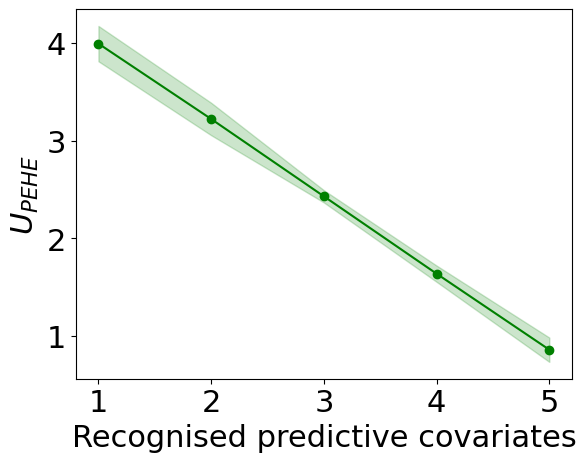

In [49]:
x = [1,2,3,4,5]
u_pehe = results.groupby('n_known').mean()['u_pehe']
#u_policy = results.groupby('n_known').mean()['u_policy']
u_pehe_std = results.groupby('n_known').std()['u_pehe'] / np.sqrt(5) * 1.96
#u_policy_std = results.groupby('n_known').std()['u_policy'] / np.sqrt(5) * 1.96

#fig, ax1 = plt.subplots()
#ax1.plot(x, u_policy, 'o-', label = 'Policy')
#ax1.fill_between(x, u_policy - u_policy_std, u_policy + u_policy_std, alpha=0.2)
#ax1.set_ylabel('Policy/Interpretability')


plt.plot(x, u_pehe, 'o-', label = 'PEHE', color='g')
plt.ylabel('$U_{PEHE}$')
plt.fill_between(x, u_pehe - u_pehe_std, u_pehe + u_pehe_std, alpha=0.2, color='g')

#handles1, labels1 = ax1.get_legend_handles_labels()
#handles2, labels2 = ax2.get_legend_handles_labels()
#handles = handles1+handles2
#labels=labels1+labels2
plt.xlabel('Recognised predictive covariates')
plt.savefig('plots/utility_metric_plot.pdf', bbox_inches='tight')

# Model selection

In [ ]:
def generate_sequentially_to_w_test(real, gen, treatment_col, outcome_col, encode=False, private=False, epsilon=None, delta=None):
    random.seed()

    #generate covariates
    if private:
        g = Plugins().get(gen, random_state = random.randint(0, 1000000), epsilon=epsilon, delta=delta)
    else:
        g = Plugins().get(gen, random_state = random.randint(0, 1000000),min_node_size=2)
    real_cov = real.drop([treatment_col, outcome_col], axis=1)
    print(f'Fitting {gen} covariate model')
    g.fit(real_cov)
    print(f'Generating {gen} synthetic covariates')
    synth_cov = g.generate(count = len(real)).dataframe()

    if encode:
        real_encoded, syn_encoded = encode_acic(real, synth_cov)
    else:
        real_encoded, syn_encoded = real, synth_cov

    #generate propensities
    X = np.array(real_encoded.drop([treatment_col, outcome_col], axis=1))
    y = np.array(real_encoded[treatment_col])
    
    if private:
        classifier = LogisticRegressionDP(random_state = random.randint(0, 1000000), epsilon=epsilon)
    else:
        classifier = LogisticRegression(random_state = random.randint(0, 1000000))
    print('Fitting propensity model')
    classifier.fit(X, y)
    print('Generating propensities')
    probabilities = classifier.predict_proba(np.array(syn_encoded))
    prob_class_1 = probabilities[:, 1]
    binary_outcomes = np.random.binomial(n=1, p=prob_class_1)

    synth_cov_with_prop = syn_encoded
    synth_cov_with_prop[treatment_col] = pd.Series(binary_outcomes)

    synth_cov_with_prop[outcome_col] = 0

    return synth_cov_with_prop

In [ ]:
def generate_sequentially_test(real, gen, treatment_col, outcome_col, encode=False, private=False, epsilon=None, delta=None):
    random.seed()
    synth = generate_sequentially_to_w_test(real, gen, treatment_col, outcome_col, encode=encode, private=private, epsilon=epsilon, delta=delta)

    X = np.array(real.drop([treatment_col, outcome_col], axis=1))
    y = np.array(real[outcome_col])
    w = np.array(real[treatment_col])
    n_units = len(real.drop([treatment_col, outcome_col], axis=1).columns)
    if private:
        l = TLearnerDP(n_unit_in=n_units, binary_y=False, seed=random.randint(0,1000000), batch_norm=False)
        print('Fitting private CATE learner')
        l.fit(X, y, w, epsilon=epsilon, delta=delta)
    else:
        l = TLearner(n_unit_in=n_units, binary_y=False, seed=random.randint(0,1000000), batch_norm=False)
        print('Fitting CATE learner')
        l.fit(X, y, w)

    seq_X = np.array(synth.drop([treatment_col, outcome_col], axis=1))
    print('Generating POs')
    cate, y0, y1 = l.predict(seq_X, return_po=True)

    outcomes = []
    for index, value in synth[treatment_col].iteritems():
        if value == 0:
            outcomes.append(y0[index].item())
        else:
            outcomes.append(y1[index].item())

    synth[outcome_col] = outcomes
    return synth

In [ ]:
def generate_standard_test(real, gen, private=False, epsilon=None, delta=None):
    random.seed()
    if private:
        g = Plugins().get(gen, random_state = random.randint(0, 1000000), epsilon=epsilon, delta=delta)
    else:
        g = Plugins().get(gen, random_state = random.randint(0, 1000000), min_node_size=2)
    print(f'Fitting {gen} model')
    g.fit(real)
    print(f'Generating {gen} synthetic dataset')
    synth = g.generate(count = len(real)).dataframe()
    return synth

In [ ]:
def model_selection_exp(n, d, n_c, n_t, n_iter):
    results = pd.DataFrame(columns = ['method', 'alpha', 'beta', 'f', 'c', 'd', 'u_pehe', 'oracle_pehe'])
    alpha = AlphaPrecision()

    X,y,w,p,t = simulate_treatment_setup(n, d=d, n_c=n_c, n_t=n_t)
    X_df = pd.DataFrame(X)
    y_df = pd.DataFrame(y, columns = ['y'])
    w_df = pd.DataFrame(w, columns = ['w'])
    d_real = pd.concat([X_df,w_df,y_df], axis=1)

    for _ in range(n_iter):
    
        d_standard = generate_standard_test(d_real, 'arf')
        X_stand = np.array(d_standard.drop(['w', 'y'], axis=1))
        y_stand = np.array(d_standard['y'])
        w_stand = np.array(d_standard['w'])

        l_stand = SLearner(n_unit_in=d, binary_y=False, seed=random.randint(0,1000000))
        l_stand.fit(X_stand, y_stand, w_stand)
        pred_stand = l_stand.predict(X)
        oracle_standard = mean_squared_error(t, pred_stand.detach().cpu().numpy(), squared=False)

        d_seq = generate_sequentially_test(d_real, 'arf', 'w', 'y')
        X_seq = np.array(d_seq.drop(['w', 'y'], axis=1))
        y_seq = np.array(d_seq['y'])
        w_seq = np.array(d_seq['w'])

        l_seq = SLearner(n_unit_in=d, binary_y=False, seed=random.randint(0,1000000))
        l_seq.fit(X_seq, y_seq, w_seq)
        pred_seq = l_seq.predict(X)
        oracle_seq = mean_squared_error(t, pred_seq.detach().cpu().numpy(), squared=False)

        results.loc[len(results)] = ['standard', alpha.evaluate(GenericDataLoader(d_real), GenericDataLoader(d_standard))['delta_precision_alpha_OC'], 
            alpha.evaluate(GenericDataLoader(d_real), GenericDataLoader(d_standard))['delta_coverage_beta_OC'], 
            evaluate_f(d_real, d_standard, 'w', 'y'), evaluate_c(d_real, d_standard, 'w', 'y'), 
            evaluate_d(d_real, d_standard, 'w', 'y'), evaluate_average_u_pehe(d_real, d_standard, 'w', 'y', d), oracle_standard]

        results.loc[len(results)] = ['seq', alpha.evaluate(GenericDataLoader(d_real), GenericDataLoader(d_seq))['delta_precision_alpha_OC'], 
            alpha.evaluate(GenericDataLoader(d_real), GenericDataLoader(d_seq))['delta_coverage_beta_OC'], 
            evaluate_f(d_real, d_seq, 'w', 'y'), evaluate_c(d_real, d_seq, 'w', 'y'), 
            evaluate_d(d_real, d_seq, 'w', 'y'), evaluate_average_u_pehe(d_real, d_seq, 'w', 'y', d), oracle_seq]

    return results

In [ ]:
model_selection_results = model_selection_exp(1000, 40, 0, 10, 5)

[2024-05-15T04:49:05.658062+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-15T04:49:05.661529+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-15T04:49:05.662011+0000][130783][CRITICAL] module plugin_goggle load failed


Fitting arf model
Initial accuracy is 0.474
Generating arf synthetic dataset


[2024-05-15T04:49:14.726832+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-15T04:49:14.727913+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-15T04:49:14.728298+0000][130783][CRITICAL] module plugin_goggle load failed


Fitting arf covariate model
Initial accuracy is 0.4425
Generating arf synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-15T04:51:51.066177+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-15T04:51:51.067666+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-15T04:51:51.068189+0000][130783][CRITICAL] module plugin_goggle load failed


Fitting arf model
Initial accuracy is 0.4845
Generating arf synthetic dataset


[2024-05-15T04:51:59.868621+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-15T04:51:59.869429+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-15T04:51:59.869789+0000][130783][CRITICAL] module plugin_goggle load failed


Fitting arf covariate model
Initial accuracy is 0.4405
Generating arf synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-15T04:54:32.485794+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-15T04:54:32.487290+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-15T04:54:32.487748+0000][130783][CRITICAL] module plugin_goggle load failed


Fitting arf model
Initial accuracy is 0.4525
Generating arf synthetic dataset


[2024-05-15T04:54:41.959703+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-15T04:54:41.960608+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-15T04:54:41.961105+0000][130783][CRITICAL] module plugin_goggle load failed


Fitting arf covariate model
Initial accuracy is 0.4605
Generating arf synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-15T04:57:17.974836+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-15T04:57:17.975881+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-15T04:57:17.976382+0000][130783][CRITICAL] module plugin_goggle load failed


Fitting arf model
Initial accuracy is 0.4645
Generating arf synthetic dataset


[2024-05-15T04:57:27.217498+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-15T04:57:27.218492+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-15T04:57:27.218864+0000][130783][CRITICAL] module plugin_goggle load failed


Fitting arf covariate model
Initial accuracy is 0.4445
Generating arf synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-15T05:00:03.730602+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-15T05:00:03.731833+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-15T05:00:03.732155+0000][130783][CRITICAL] module plugin_goggle load failed


Fitting arf model
Initial accuracy is 0.471
Generating arf synthetic dataset


[2024-05-15T05:00:13.357324+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-15T05:00:13.358270+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-15T05:00:13.358675+0000][130783][CRITICAL] module plugin_goggle load failed


Fitting arf covariate model
Initial accuracy is 0.442
Generating arf synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


In [ ]:
model_selection_results.groupby('method').mean()

,alpha,beta,f,c,d,u_pehe,oracle_pehe
method,,,,,,,
seq,0.193773,0.171493,0.221067,0.176933,0.821901,4.360505,4.620599
standard,0.177760,0.176453,0.215760,0.191907,0.783126,7.174803,8.398304


In [ ]:
model_selection_results.groupby('method').std() / np.sqrt(5) * 1.96

,alpha,beta,f,c,d,u_pehe,oracle_pehe
method,,,,,,,
seq,0.013049,0.033278,0.008178,0.021495,0.016053,0.241828,0.065125
standard,0.018215,0.015844,0.007146,0.012139,0.021359,0.146867,0.142550


In [ ]:
model_selection_results.corr()

,alpha,beta,f,c,d,u_pehe,oracle_pehe
alpha,1.000000,0.588134,0.303387,0.169600,0.348789,-0.432350,-0.467389
beta,0.588134,1.000000,0.321706,0.371152,-0.217302,0.122261,0.083957
f,0.303387,0.321706,1.000000,0.216046,0.080783,-0.318053,-0.338153
c,0.169600,0.371152,0.216046,1.000000,0.078889,0.398354,0.375924
d,0.348789,-0.217302,0.080783,0.078889,1.000000,-0.730445,-0.715735
u_pehe,-0.432350,0.122261,-0.318053,0.398354,-0.730445,1.000000,0.988996
oracle_pehe,-0.467389,0.083957,-0.338153,0.375924,-0.715735,0.988996,1.000000


In [ ]:
model_selection_results.to_csv('model_selection_exp_arf.csv', index=False)

# Real world experiments

### Generation in a sequential manner, mimicing the true DGP

Given a real dataset $D = [X, W, Y]$, will train a generative model only on the covariates $X$. Then will predict the treatment assignment $W$ based on the propensity score $\pi(x)$ for each instance, where $\pi(.)$ is learnt from the real dataset. Then, will generate the outcomes $Y$ based on a conditional generative model that has been trained on $D$.

In [60]:
results = seq_test(ihdp, 'ctgan', 'treatment', 'y_factual', 20, save=True, fp='ihdp_sequential_vs_standard_ctgan.csv')

[2024-05-20T11:22:26.032543+0000][1471397][CRITICAL] load failed: Cannot find DGL C++ graphbolt library at /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/dgl/graphbolt/libgraphbolt_pytorch_1.13.1.so
[2024-05-20T11:22:26.033589+0000][1471397][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-20T11:22:26.034073+0000][1471397][CRITICAL] module plugin_goggle load failed


Fitting ctgan model


 57%|█████▋    | 1149/2000 [01:59<01:28,  9.58it/s]
[2024-05-20T11:24:28.913353+0000][1471397][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-20T11:24:28.914228+0000][1471397][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-20T11:24:28.914749+0000][1471397][CRITICAL] module plugin_goggle load failed


Generating ctgan synthetic dataset
Fitting ctgan covariate model


 37%|███▋      | 749/2000 [01:15<02:05,  9.93it/s]


Generating ctgan synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-20T11:28:59.707282+0000][1471397][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-20T11:28:59.709185+0000][1471397][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-20T11:28:59.709573+0000][1471397][CRITICAL] module plugin_goggle load failed


Fitting ctgan model


 25%|██▍       | 499/2000 [01:02<03:07,  8.01it/s]
[2024-05-20T11:30:03.139909+0000][1471397][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-20T11:30:03.140600+0000][1471397][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-20T11:30:03.141007+0000][1471397][CRITICAL] module plugin_goggle load failed


Generating ctgan synthetic dataset
Fitting ctgan covariate model


 32%|███▏      | 649/2000 [01:18<02:42,  8.29it/s]


Generating ctgan synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-20T11:34:30.725452+0000][1471397][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-20T11:34:30.726672+0000][1471397][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-20T11:34:30.727139+0000][1471397][CRITICAL] module plugin_goggle load failed


Fitting ctgan model


 62%|██████▏   | 1249/2000 [02:34<01:33,  8.08it/s]
[2024-05-20T11:37:06.515272+0000][1471397][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-20T11:37:06.515846+0000][1471397][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-20T11:37:06.516277+0000][1471397][CRITICAL] module plugin_goggle load failed


Generating ctgan synthetic dataset
Fitting ctgan covariate model


 32%|███▏      | 649/2000 [01:05<02:16,  9.90it/s]


Generating ctgan synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-20T11:41:25.770934+0000][1471397][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-20T11:41:25.773790+0000][1471397][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-20T11:41:25.774408+0000][1471397][CRITICAL] module plugin_goggle load failed


Fitting ctgan model


 35%|███▍      | 699/2000 [01:27<02:42,  7.98it/s]
[2024-05-20T11:42:54.449354+0000][1471397][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-20T11:42:54.449929+0000][1471397][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-20T11:42:54.450311+0000][1471397][CRITICAL] module plugin_goggle load failed


Generating ctgan synthetic dataset
Fitting ctgan covariate model


 45%|████▍     | 899/2000 [01:48<02:13,  8.25it/s]


Generating ctgan synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-20T11:48:03.383185+0000][1471397][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-20T11:48:03.384494+0000][1471397][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-20T11:48:03.385022+0000][1471397][CRITICAL] module plugin_goggle load failed


Fitting ctgan model


 40%|███▉      | 799/2000 [01:39<02:28,  8.06it/s]
[2024-05-20T11:49:43.562453+0000][1471397][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-20T11:49:43.563056+0000][1471397][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-20T11:49:43.563429+0000][1471397][CRITICAL] module plugin_goggle load failed


Generating ctgan synthetic dataset
Fitting ctgan covariate model


 27%|██▋       | 549/2000 [00:55<02:26,  9.90it/s]


Generating ctgan synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-20T11:53:52.614740+0000][1471397][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-20T11:53:52.617239+0000][1471397][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-20T11:53:52.617916+0000][1471397][CRITICAL] module plugin_goggle load failed


Fitting ctgan model


 40%|███▉      | 799/2000 [01:39<02:30,  8.00it/s]
[2024-05-20T11:55:33.615356+0000][1471397][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-20T11:55:33.616042+0000][1471397][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-20T11:55:33.616482+0000][1471397][CRITICAL] module plugin_goggle load failed


Generating ctgan synthetic dataset
Fitting ctgan covariate model


 50%|████▉     | 999/2000 [01:58<01:58,  8.43it/s]


Generating ctgan synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-20T12:00:43.676058+0000][1471397][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-20T12:00:43.677279+0000][1471397][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-20T12:00:43.677773+0000][1471397][CRITICAL] module plugin_goggle load failed


Fitting ctgan model


 15%|█▍        | 299/2000 [00:36<03:30,  8.09it/s]
[2024-05-20T12:01:21.749816+0000][1471397][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-20T12:01:21.750557+0000][1471397][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-20T12:01:21.751089+0000][1471397][CRITICAL] module plugin_goggle load failed


Generating ctgan synthetic dataset
Fitting ctgan covariate model


 22%|██▏       | 449/2000 [00:45<02:35,  9.96it/s]


Generating ctgan synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


Bad pipe message: %s [b'\x80.\xba\x0b\x001\xfd\x05\xe3\xe8\x1e\xa5\xb0\x1a\xe5\xf5\xf1']
Bad pipe message: %s [b'\x9e\x12j\xb8\x13!\x1f\x82\xfeW=\xf2<\xe61#7\xf2\xfd\r\x0b\x1e\xdb\x04\xb3\xc7\x82\x05W\xb9\xea\x05\x00\x08\x13\x02\x13\x03\x13\x01\x00\xff\x01\x00']
Bad pipe message: %s [b'\xc5Y{_!{z\xf6\x9d\x11\xc4\xa7\xe2\xd5\xac\x8fu\xa5 \xdfq\t\xc7\xe6\x1f\xa8\x85\x7f\xe6d\xef\x1e\x8d\xb8\xe8q\xbe\xa50\xd6\xa7\xaaj\x8c:\xdbo\xeavY\xab\x00\x08\x13\x02\x13\x03\x13\x01\x00\xff\x01\x00\x00\x8f\x00\x00\x00\x0e\x00\x0c']
Bad pipe message: %s [b'\xc3\xab\x14\xf3\xa1\x9d\x10N\x86H\x0b\x1a\xce\xb2\xf8\xb1\x87\r\x00\x00|\xc0,\xc00\x00\xa3\x00\x9f\xcc\xa9\xcc\xa8\xcc\xaa\xc0\xaf\xc0\xad\xc0\xa3\xc0\x9f\xc0]\xc0a\xc0W\xc0S\xc0+']
Bad pipe message: %s [b"\x00\xa2\x00\x9e\xc0\xae\xc0\xac\xc0\xa2\xc0\x9e\xc0\\\xc0`\xc0V\xc0R\xc0$\xc0(\x00k\x00j\xc0#\xc0'\x00g\x00@\xc0\n\xc0\x14\x009\x008\xc0\t\xc0\x13\x003\x002\x00\x9d\xc0\xa1\xc0\x9d\xc0Q\x00\x9c\xc0\xa0\xc0\x9c\xc0P\x00=\x00<\x005\x00/\x00\x9a\x00\

Fitting ctgan model


 37%|███▋      | 749/2000 [01:32<02:34,  8.11it/s]
[2024-05-20T12:07:03.769836+0000][1471397][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-20T12:07:03.770575+0000][1471397][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-20T12:07:03.770998+0000][1471397][CRITICAL] module plugin_goggle load failed


Generating ctgan synthetic dataset
Fitting ctgan covariate model


 42%|████▏     | 849/2000 [01:25<01:55,  9.96it/s]


Generating ctgan synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-20T12:11:48.696178+0000][1471397][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-20T12:11:48.698713+0000][1471397][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-20T12:11:48.699766+0000][1471397][CRITICAL] module plugin_goggle load failed


Fitting ctgan model


 55%|█████▍    | 1099/2000 [01:53<01:33,  9.64it/s]
[2024-05-20T12:13:43.822174+0000][1471397][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-20T12:13:43.822869+0000][1471397][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-20T12:13:43.823328+0000][1471397][CRITICAL] module plugin_goggle load failed


Generating ctgan synthetic dataset
Fitting ctgan covariate model


 15%|█▍        | 299/2000 [00:30<02:54,  9.73it/s]


Generating ctgan synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-20T12:17:25.922458+0000][1471397][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-20T12:17:25.924975+0000][1471397][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-20T12:17:25.926006+0000][1471397][CRITICAL] module plugin_goggle load failed


Fitting ctgan model


 32%|███▏      | 649/2000 [01:08<02:23,  9.43it/s]


Generating ctgan synthetic dataset


[2024-05-20T12:18:36.112528+0000][1471397][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-20T12:18:36.113259+0000][1471397][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-20T12:18:36.113721+0000][1471397][CRITICAL] module plugin_goggle load failed


Fitting ctgan covariate model


 35%|███▍      | 699/2000 [01:10<02:10,  9.98it/s]


Generating ctgan synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-20T12:22:59.347504+0000][1471397][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-20T12:22:59.348748+0000][1471397][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-20T12:22:59.349099+0000][1471397][CRITICAL] module plugin_goggle load failed


Fitting ctgan model


 57%|█████▋    | 1149/2000 [02:23<01:45,  8.03it/s]
[2024-05-20T12:25:23.572787+0000][1471397][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-20T12:25:23.573361+0000][1471397][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-20T12:25:23.573742+0000][1471397][CRITICAL] module plugin_goggle load failed


Generating ctgan synthetic dataset
Fitting ctgan covariate model


 47%|████▋     | 949/2000 [01:34<01:45, 10.01it/s]


Generating ctgan synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-20T12:30:16.947645+0000][1471397][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-20T12:30:16.950158+0000][1471397][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-20T12:30:16.951138+0000][1471397][CRITICAL] module plugin_goggle load failed


Fitting ctgan model


 47%|████▋     | 949/2000 [01:55<02:07,  8.24it/s]
[2024-05-20T12:32:13.266657+0000][1471397][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-20T12:32:13.267284+0000][1471397][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-20T12:32:13.267795+0000][1471397][CRITICAL] module plugin_goggle load failed


Generating ctgan synthetic dataset
Fitting ctgan covariate model


 25%|██▍       | 499/2000 [00:49<02:28, 10.08it/s]


Generating ctgan synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-20T12:36:18.667573+0000][1471397][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-20T12:36:18.669835+0000][1471397][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-20T12:36:18.670819+0000][1471397][CRITICAL] module plugin_goggle load failed


Fitting ctgan model


 47%|████▋     | 949/2000 [01:37<01:47,  9.76it/s]
[2024-05-20T12:37:57.039182+0000][1471397][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-20T12:37:57.039910+0000][1471397][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-20T12:37:57.040405+0000][1471397][CRITICAL] module plugin_goggle load failed


Generating ctgan synthetic dataset
Fitting ctgan covariate model


 40%|███▉      | 799/2000 [01:19<01:58, 10.10it/s]


Generating ctgan synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-20T12:42:25.762492+0000][1471397][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-20T12:42:25.764741+0000][1471397][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-20T12:42:25.765437+0000][1471397][CRITICAL] module plugin_goggle load failed


Fitting ctgan model


 62%|██████▏   | 1249/2000 [02:07<01:16,  9.78it/s]
[2024-05-20T12:44:34.541596+0000][1471397][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-20T12:44:34.542378+0000][1471397][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-20T12:44:34.543140+0000][1471397][CRITICAL] module plugin_goggle load failed


Generating ctgan synthetic dataset
Fitting ctgan covariate model


 67%|██████▋   | 1349/2000 [02:19<01:07,  9.68it/s]


Generating ctgan synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-20T12:50:02.519265+0000][1471397][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-20T12:50:02.521536+0000][1471397][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-20T12:50:02.522028+0000][1471397][CRITICAL] module plugin_goggle load failed


Fitting ctgan model


 35%|███▍      | 699/2000 [01:11<02:12,  9.81it/s]
[2024-05-20T12:51:14.861611+0000][1471397][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-20T12:51:14.862311+0000][1471397][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-20T12:51:14.862890+0000][1471397][CRITICAL] module plugin_goggle load failed


Generating ctgan synthetic dataset
Fitting ctgan covariate model


 40%|███▉      | 799/2000 [01:18<01:58, 10.16it/s]


Generating ctgan synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-20T12:55:42.427642+0000][1471397][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-20T12:55:42.429824+0000][1471397][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-20T12:55:42.430376+0000][1471397][CRITICAL] module plugin_goggle load failed


Fitting ctgan model


 25%|██▍       | 499/2000 [00:51<02:33,  9.75it/s]
[2024-05-20T12:56:34.715114+0000][1471397][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-20T12:56:34.715775+0000][1471397][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-20T12:56:34.716192+0000][1471397][CRITICAL] module plugin_goggle load failed


Generating ctgan synthetic dataset
Fitting ctgan covariate model


 52%|█████▏    | 1049/2000 [01:43<01:33, 10.17it/s]


Generating ctgan synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-20T13:01:33.422910+0000][1471397][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-20T13:01:33.425974+0000][1471397][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-20T13:01:33.426502+0000][1471397][CRITICAL] module plugin_goggle load failed


Fitting ctgan model


 37%|███▋      | 749/2000 [01:16<02:07,  9.84it/s]
[2024-05-20T13:02:50.654646+0000][1471397][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-20T13:02:50.655253+0000][1471397][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-20T13:02:50.655636+0000][1471397][CRITICAL] module plugin_goggle load failed


Generating ctgan synthetic dataset
Fitting ctgan covariate model


 27%|██▋       | 549/2000 [00:53<02:22, 10.22it/s]


Generating ctgan synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-20T13:06:49.022151+0000][1471397][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-20T13:06:49.024275+0000][1471397][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-20T13:06:49.025285+0000][1471397][CRITICAL] module plugin_goggle load failed


Fitting ctgan model


 30%|██▉       | 599/2000 [01:03<02:27,  9.49it/s]
[2024-05-20T13:07:53.274272+0000][1471397][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-20T13:07:53.274930+0000][1471397][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-20T13:07:53.275312+0000][1471397][CRITICAL] module plugin_goggle load failed


Generating ctgan synthetic dataset
Fitting ctgan covariate model


 30%|██▉       | 599/2000 [01:01<02:23,  9.73it/s]


Generating ctgan synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-20T13:12:06.060615+0000][1471397][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-20T13:12:06.062898+0000][1471397][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-20T13:12:06.064009+0000][1471397][CRITICAL] module plugin_goggle load failed


Fitting ctgan model


 65%|██████▍   | 1299/2000 [02:12<01:11,  9.79it/s]
[2024-05-20T13:14:19.847532+0000][1471397][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-20T13:14:19.848289+0000][1471397][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-20T13:14:19.848768+0000][1471397][CRITICAL] module plugin_goggle load failed


Generating ctgan synthetic dataset
Fitting ctgan covariate model


 32%|███▏      | 649/2000 [01:03<02:11, 10.25it/s]


Generating ctgan synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-20T13:18:32.619458+0000][1471397][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-20T13:18:32.620696+0000][1471397][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-20T13:18:32.621056+0000][1471397][CRITICAL] module plugin_goggle load failed


Fitting ctgan model


 42%|████▏     | 849/2000 [01:48<02:26,  7.86it/s]
[2024-05-20T13:20:21.756836+0000][1471397][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-20T13:20:21.757531+0000][1471397][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-20T13:20:21.758113+0000][1471397][CRITICAL] module plugin_goggle load failed


Generating ctgan synthetic dataset
Fitting ctgan covariate model


 45%|████▍     | 899/2000 [01:28<01:48, 10.12it/s]


Generating ctgan synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


In [26]:
results = seq_test(ihdp, 'arf', 'treatment', 'y_factual', 20, save=True, fp='ihdp_sequential_vs_standard_arf.csv', binary_y=False)

[2024-05-17T13:15:41.540427+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-17T13:15:41.541895+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-17T13:15:41.542366+0000][1043622][CRITICAL] module plugin_goggle load failed


Fitting arf model
Initial accuracy is 0.8018741633199464
Iteration number 1 reached accuracy of 0.501338688085676.
Iteration number 2 reached accuracy of 0.4779116465863454.
Generating arf synthetic dataset


[2024-05-17T13:15:55.781560+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-17T13:15:55.782580+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-17T13:15:55.782974+0000][1043622][CRITICAL] module plugin_goggle load failed


Fitting arf covariate model
Initial accuracy is 0.8253012048192772
Iteration number 1 reached accuracy of 0.4886211512717537.
Generating arf synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-17T13:19:26.581055+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-17T13:19:26.582415+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-17T13:19:26.582895+0000][1043622][CRITICAL] module plugin_goggle load failed


Fitting arf model
Initial accuracy is 0.8159303882195449
Iteration number 1 reached accuracy of 0.5113788487282463.
Iteration number 2 reached accuracy of 0.5020080321285141.
Iteration number 3 reached accuracy of 0.500669344042838.
Iteration number 4 reached accuracy of 0.4933065595716198.
Generating arf synthetic dataset


[2024-05-17T13:19:50.937426+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-17T13:19:50.938696+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-17T13:19:50.939087+0000][1043622][CRITICAL] module plugin_goggle load failed


Fitting arf covariate model
Initial accuracy is 0.821954484605087
Iteration number 1 reached accuracy of 0.47121820615796517.
Generating arf synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-17T13:23:18.747960+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-17T13:23:18.750836+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-17T13:23:18.751516+0000][1043622][CRITICAL] module plugin_goggle load failed


Fitting arf model
Initial accuracy is 0.8266398929049531
Iteration number 1 reached accuracy of 0.5020080321285141.
Iteration number 2 reached accuracy of 0.5294511378848729.
Generating arf synthetic dataset


[2024-05-17T13:23:32.783890+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-17T13:23:32.785126+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-17T13:23:32.785502+0000][1043622][CRITICAL] module plugin_goggle load failed


Fitting arf covariate model
Initial accuracy is 0.8065595716198126
Iteration number 1 reached accuracy of 0.4926372155287818.
Generating arf synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-17T13:26:59.351546+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-17T13:26:59.354225+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-17T13:26:59.354856+0000][1043622][CRITICAL] module plugin_goggle load failed


Fitting arf model
Initial accuracy is 0.8125836680053548
Iteration number 1 reached accuracy of 0.5214190093708166.
Iteration number 2 reached accuracy of 0.5066934404283802.
Iteration number 3 reached accuracy of 0.49732262382864795.
Generating arf synthetic dataset


[2024-05-17T13:27:18.698015+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-17T13:27:18.698926+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-17T13:27:18.699496+0000][1043622][CRITICAL] module plugin_goggle load failed


Fitting arf covariate model
Initial accuracy is 0.7817938420348058
Iteration number 1 reached accuracy of 0.5046854082998661.
Iteration number 2 reached accuracy of 0.46184738955823296.
Generating arf synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-17T13:30:45.309877+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-17T13:30:45.312794+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-17T13:30:45.313426+0000][1043622][CRITICAL] module plugin_goggle load failed


Fitting arf model
Initial accuracy is 0.8132530120481928
Iteration number 1 reached accuracy of 0.5247657295850067.
Iteration number 2 reached accuracy of 0.4799196787148594.
Generating arf synthetic dataset


[2024-05-17T13:30:59.972134+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-17T13:30:59.972922+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-17T13:30:59.973350+0000][1043622][CRITICAL] module plugin_goggle load failed


Fitting arf covariate model
Initial accuracy is 0.8105756358768407
Iteration number 1 reached accuracy of 0.49464524765729584.
Generating arf synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-17T13:34:26.604553+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-17T13:34:26.607113+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-17T13:34:26.607730+0000][1043622][CRITICAL] module plugin_goggle load failed


Fitting arf model
Initial accuracy is 0.8139223560910308
Iteration number 1 reached accuracy of 0.49732262382864795.
Generating arf synthetic dataset


[2024-05-17T13:34:36.271991+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-17T13:34:36.273009+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-17T13:34:36.273370+0000][1043622][CRITICAL] module plugin_goggle load failed


Fitting arf covariate model
Initial accuracy is 0.8179384203480589
Iteration number 1 reached accuracy of 0.48326639892904955.
Generating arf synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-17T13:37:54.832680+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-17T13:37:54.834841+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-17T13:37:54.835256+0000][1043622][CRITICAL] module plugin_goggle load failed


Fitting arf model
Initial accuracy is 0.8165997322623829
Iteration number 1 reached accuracy of 0.499330655957162.
Generating arf synthetic dataset


[2024-05-17T13:38:04.463062+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-17T13:38:04.463779+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-17T13:38:04.464168+0000][1043622][CRITICAL] module plugin_goggle load failed


Fitting arf covariate model
Initial accuracy is 0.8186077643908969
Iteration number 1 reached accuracy of 0.48058902275769744.
Generating arf synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-17T13:41:30.754522+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-17T13:41:30.756033+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-17T13:41:30.756593+0000][1043622][CRITICAL] module plugin_goggle load failed


Fitting arf model
Initial accuracy is 0.8246318607764391
Iteration number 1 reached accuracy of 0.5194109772423026.
Iteration number 2 reached accuracy of 0.4939759036144578.
Generating arf synthetic dataset


[2024-05-17T13:41:45.451753+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-17T13:41:45.452570+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-17T13:41:45.453010+0000][1043622][CRITICAL] module plugin_goggle load failed


Fitting arf covariate model
Initial accuracy is 0.7978580990629184
Iteration number 1 reached accuracy of 0.4785809906291834.
Generating arf synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-17T13:45:11.655187+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-17T13:45:11.657833+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-17T13:45:11.658494+0000][1043622][CRITICAL] module plugin_goggle load failed


Fitting arf model
Initial accuracy is 0.8172690763052208
Iteration number 1 reached accuracy of 0.4892904953145917.
Generating arf synthetic dataset


[2024-05-17T13:45:21.151975+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-17T13:45:21.153162+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-17T13:45:21.153607+0000][1043622][CRITICAL] module plugin_goggle load failed


Fitting arf covariate model
Initial accuracy is 0.7958500669344043
Iteration number 1 reached accuracy of 0.5020080321285141.
Iteration number 2 reached accuracy of 0.47523427041499333.
Generating arf synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-17T13:48:46.648397+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-17T13:48:46.650990+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-17T13:48:46.651649+0000][1043622][CRITICAL] module plugin_goggle load failed


Fitting arf model
Initial accuracy is 0.8246318607764391
Iteration number 1 reached accuracy of 0.5093708165997323.
Iteration number 2 reached accuracy of 0.48728246318607765.
Generating arf synthetic dataset


[2024-05-17T13:49:00.826362+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-17T13:49:00.827092+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-17T13:49:00.827483+0000][1043622][CRITICAL] module plugin_goggle load failed


Fitting arf covariate model
Initial accuracy is 0.8065595716198126
Iteration number 1 reached accuracy of 0.4966532797858099.
Generating arf synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-17T13:52:17.609860+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-17T13:52:17.612228+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-17T13:52:17.613281+0000][1043622][CRITICAL] module plugin_goggle load failed


Fitting arf model
Initial accuracy is 0.8099062918340026
Iteration number 1 reached accuracy of 0.5087014725568942.
Iteration number 2 reached accuracy of 0.5214190093708166.
Generating arf synthetic dataset


[2024-05-17T13:52:31.830881+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-17T13:52:31.831646+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-17T13:52:31.832162+0000][1043622][CRITICAL] module plugin_goggle load failed


Fitting arf covariate model
Initial accuracy is 0.8373493975903614
Iteration number 1 reached accuracy of 0.5133868808567604.
Iteration number 2 reached accuracy of 0.46117804551539493.
Generating arf synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-17T13:55:55.718135+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-17T13:55:55.719518+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-17T13:55:55.720014+0000][1043622][CRITICAL] module plugin_goggle load failed


Fitting arf model
Initial accuracy is 0.8092369477911646
Iteration number 1 reached accuracy of 0.49062918340026773.
Generating arf synthetic dataset


[2024-05-17T13:56:05.136626+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-17T13:56:05.137287+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-17T13:56:05.137811+0000][1043622][CRITICAL] module plugin_goggle load failed


Fitting arf covariate model
Initial accuracy is 0.8005354752342704
Iteration number 1 reached accuracy of 0.49464524765729584.
Generating arf synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-17T13:59:24.072388+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-17T13:59:24.074784+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-17T13:59:24.075469+0000][1043622][CRITICAL] module plugin_goggle load failed


Fitting arf model
Initial accuracy is 0.8085676037483266
Iteration number 1 reached accuracy of 0.5153949129852744.
Iteration number 2 reached accuracy of 0.5020080321285141.
Iteration number 3 reached accuracy of 0.4745649263721553.
Generating arf synthetic dataset


[2024-05-17T13:59:43.189415+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-17T13:59:43.190063+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-17T13:59:43.190430+0000][1043622][CRITICAL] module plugin_goggle load failed


Fitting arf covariate model
Initial accuracy is 0.8192771084337349
Iteration number 1 reached accuracy of 0.4725568942436412.
Generating arf synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-17T14:03:01.914723+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-17T14:03:01.916534+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-17T14:03:01.917197+0000][1043622][CRITICAL] module plugin_goggle load failed


Fitting arf model
Initial accuracy is 0.7730923694779116
Iteration number 1 reached accuracy of 0.48460508701472554.
Generating arf synthetic dataset


[2024-05-17T14:03:11.837419+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-17T14:03:11.838493+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-17T14:03:11.838879+0000][1043622][CRITICAL] module plugin_goggle load failed


Fitting arf covariate model
Initial accuracy is 0.8038821954484605
Iteration number 1 reached accuracy of 0.5053547523427041.
Iteration number 2 reached accuracy of 0.5033467202141901.
Iteration number 3 reached accuracy of 0.464524765729585.
Generating arf synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-17T14:06:36.371304+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-17T14:06:36.373752+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-17T14:06:36.374408+0000][1043622][CRITICAL] module plugin_goggle load failed


Fitting arf model
Initial accuracy is 0.8239625167336011
Iteration number 1 reached accuracy of 0.5113788487282463.
Iteration number 2 reached accuracy of 0.5020080321285141.
Iteration number 3 reached accuracy of 0.4799196787148594.
Generating arf synthetic dataset


[2024-05-17T14:06:55.198752+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-17T14:06:55.199689+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-17T14:06:55.200069+0000][1043622][CRITICAL] module plugin_goggle load failed


Fitting arf covariate model
Initial accuracy is 0.8058902275769746
Iteration number 1 reached accuracy of 0.47523427041499333.
Generating arf synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-17T14:10:17.610281+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-17T14:10:17.611591+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-17T14:10:17.612115+0000][1043622][CRITICAL] module plugin_goggle load failed


Fitting arf model
Initial accuracy is 0.7965194109772423
Iteration number 1 reached accuracy of 0.5227576974564926.
Iteration number 2 reached accuracy of 0.5.
Generating arf synthetic dataset


[2024-05-17T14:10:31.604611+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-17T14:10:31.605322+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-17T14:10:31.605725+0000][1043622][CRITICAL] module plugin_goggle load failed


Fitting arf covariate model
Initial accuracy is 0.7965194109772423
Iteration number 1 reached accuracy of 0.5120481927710844.
Iteration number 2 reached accuracy of 0.4585006693440428.
Generating arf synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-17T14:13:58.263869+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-17T14:13:58.266406+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-17T14:13:58.266946+0000][1043622][CRITICAL] module plugin_goggle load failed


Fitting arf model
Initial accuracy is 0.8045515394912985
Iteration number 1 reached accuracy of 0.5194109772423026.
Iteration number 2 reached accuracy of 0.5.
Generating arf synthetic dataset


[2024-05-17T14:14:11.733221+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-17T14:14:11.734509+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-17T14:14:11.734941+0000][1043622][CRITICAL] module plugin_goggle load failed


Fitting arf covariate model
Initial accuracy is 0.8313253012048193
Iteration number 1 reached accuracy of 0.5187416331994645.
Iteration number 2 reached accuracy of 0.47724230254350736.
Generating arf synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-17T14:17:24.610773+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-17T14:17:24.612969+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-17T14:17:24.614046+0000][1043622][CRITICAL] module plugin_goggle load failed


Fitting arf model
Initial accuracy is 0.7965194109772423
Iteration number 1 reached accuracy of 0.5461847389558233.
Iteration number 2 reached accuracy of 0.4939759036144578.
Generating arf synthetic dataset


[2024-05-17T14:17:38.161322+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-17T14:17:38.161940+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-17T14:17:38.162322+0000][1043622][CRITICAL] module plugin_goggle load failed


Fitting arf covariate model
Initial accuracy is 0.8125836680053548
Iteration number 1 reached accuracy of 0.4979919678714859.
Generating arf synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-17T14:20:56.419741+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-17T14:20:56.420583+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-17T14:20:56.421044+0000][1043622][CRITICAL] module plugin_goggle load failed


Fitting arf model
Initial accuracy is 0.8139223560910308
Iteration number 1 reached accuracy of 0.5267737617135207.
Iteration number 2 reached accuracy of 0.48058902275769744.
Generating arf synthetic dataset


[2024-05-17T14:21:09.974780+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-17T14:21:09.975503+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-17T14:21:09.975929+0000][1043622][CRITICAL] module plugin_goggle load failed


Fitting arf covariate model
Initial accuracy is 0.8099062918340026
Iteration number 1 reached accuracy of 0.5220883534136547.
Iteration number 2 reached accuracy of 0.5227576974564926.
Generating arf synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-17T14:24:29.088085+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-17T14:24:29.090051+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-17T14:24:29.091123+0000][1043622][CRITICAL] module plugin_goggle load failed


Fitting arf model
Initial accuracy is 0.8078982597054887
Iteration number 1 reached accuracy of 0.4819277108433735.
Generating arf synthetic dataset


[2024-05-17T14:24:38.205574+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-17T14:24:38.206197+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-17T14:24:38.206600+0000][1043622][CRITICAL] module plugin_goggle load failed


Fitting arf covariate model
Initial accuracy is 0.8052208835341366
Iteration number 1 reached accuracy of 0.47925033467202144.
Generating arf synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


In [27]:
results_jobs = seq_test(jobs, 'arf', 'training', 're78', 20, save=True, fp='jobs_sequential_vs_standard_arf.csv')

[2024-05-17T20:58:05.704674+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-17T20:58:05.705886+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-17T20:58:05.706288+0000][1043622][CRITICAL] module plugin_goggle load failed


Fitting arf model
Initial accuracy is 0.657202216066482
Iteration number 1 reached accuracy of 0.3850415512465374.
Generating arf synthetic dataset


[2024-05-17T20:58:09.955653+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-17T20:58:09.956725+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-17T20:58:09.957091+0000][1043622][CRITICAL] module plugin_goggle load failed


Fitting arf covariate model
Initial accuracy is 0.6807479224376731
Iteration number 1 reached accuracy of 0.4002770083102493.
Generating arf synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-17T21:07:54.271466+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-17T21:07:54.273943+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-17T21:07:54.274579+0000][1043622][CRITICAL] module plugin_goggle load failed


Fitting arf model
Initial accuracy is 0.6662049861495845
Iteration number 1 reached accuracy of 0.38573407202216065.
Generating arf synthetic dataset


[2024-05-17T21:07:58.523984+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-17T21:07:58.524960+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-17T21:07:58.525490+0000][1043622][CRITICAL] module plugin_goggle load failed


Fitting arf covariate model
Initial accuracy is 0.7042936288088643
Iteration number 1 reached accuracy of 0.40581717451523547.
Generating arf synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-17T21:18:55.581513+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-17T21:18:55.584026+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-17T21:18:55.584670+0000][1043622][CRITICAL] module plugin_goggle load failed


Fitting arf model
Initial accuracy is 0.6696675900277008
Iteration number 1 reached accuracy of 0.37257617728531855.
Generating arf synthetic dataset


[2024-05-17T21:19:00.158915+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-17T21:19:00.159574+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-17T21:19:00.160039+0000][1043622][CRITICAL] module plugin_goggle load failed


Fitting arf covariate model
Initial accuracy is 0.731994459833795
Iteration number 1 reached accuracy of 0.4307479224376731.
Generating arf synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-17T21:27:26.384265+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-17T21:27:26.386966+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-17T21:27:26.387476+0000][1043622][CRITICAL] module plugin_goggle load failed


Fitting arf model
Initial accuracy is 0.6544321329639889
Iteration number 1 reached accuracy of 0.3878116343490305.
Generating arf synthetic dataset


[2024-05-17T21:27:30.622431+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-17T21:27:30.623016+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-17T21:27:30.623402+0000][1043622][CRITICAL] module plugin_goggle load failed


Fitting arf covariate model
Initial accuracy is 0.7257617728531855
Iteration number 1 reached accuracy of 0.3878116343490305.
Generating arf synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-17T21:36:58.437986+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-17T21:36:58.439090+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-17T21:36:58.439497+0000][1043622][CRITICAL] module plugin_goggle load failed


Fitting arf model
Initial accuracy is 0.6606648199445984
Iteration number 1 reached accuracy of 0.3871191135734072.
Generating arf synthetic dataset


[2024-05-17T21:37:02.735381+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-17T21:37:02.735955+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-17T21:37:02.736306+0000][1043622][CRITICAL] module plugin_goggle load failed


Fitting arf covariate model
Initial accuracy is 0.7119113573407202
Iteration number 1 reached accuracy of 0.37257617728531855.
Generating arf synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-17T21:47:48.579524+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-17T21:47:48.582324+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-17T21:47:48.582805+0000][1043622][CRITICAL] module plugin_goggle load failed


Fitting arf model
Initial accuracy is 0.675207756232687
Iteration number 1 reached accuracy of 0.41759002770083103.
Generating arf synthetic dataset


[2024-05-17T21:47:52.859771+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-17T21:47:52.860355+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-17T21:47:52.860709+0000][1043622][CRITICAL] module plugin_goggle load failed


Fitting arf covariate model
Initial accuracy is 0.7126038781163435
Iteration number 1 reached accuracy of 0.39681440443213295.
Generating arf synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-17T21:58:59.383219+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-17T21:58:59.385269+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-17T21:58:59.386253+0000][1043622][CRITICAL] module plugin_goggle load failed


Fitting arf model
Initial accuracy is 0.6876731301939059
Iteration number 1 reached accuracy of 0.39335180055401664.
Generating arf synthetic dataset


[2024-05-17T21:59:03.687371+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-17T21:59:03.688110+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-17T21:59:03.688593+0000][1043622][CRITICAL] module plugin_goggle load failed


Fitting arf covariate model
Initial accuracy is 0.6772853185595568
Iteration number 1 reached accuracy of 0.3850415512465374.
Generating arf synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-17T22:09:45.917081+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-17T22:09:45.919647+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-17T22:09:45.920339+0000][1043622][CRITICAL] module plugin_goggle load failed


Fitting arf model
Initial accuracy is 0.6980609418282548
Iteration number 1 reached accuracy of 0.3587257617728532.
Generating arf synthetic dataset


[2024-05-17T22:09:50.482729+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-17T22:09:50.483332+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-17T22:09:50.483850+0000][1043622][CRITICAL] module plugin_goggle load failed


Fitting arf covariate model
Initial accuracy is 0.6945983379501385
Iteration number 1 reached accuracy of 0.3871191135734072.
Generating arf synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-17T22:21:12.675337+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-17T22:21:12.677991+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-17T22:21:12.678519+0000][1043622][CRITICAL] module plugin_goggle load failed


Fitting arf model
Initial accuracy is 0.6966759002770083
Iteration number 1 reached accuracy of 0.40650969529085873.
Generating arf synthetic dataset


[2024-05-17T22:21:16.954882+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-17T22:21:16.955482+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-17T22:21:16.955887+0000][1043622][CRITICAL] module plugin_goggle load failed


Fitting arf covariate model
Initial accuracy is 0.693213296398892
Iteration number 1 reached accuracy of 0.38573407202216065.
Generating arf synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-17T22:31:13.220043+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-17T22:31:13.222209+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-17T22:31:13.223257+0000][1043622][CRITICAL] module plugin_goggle load failed


Fitting arf model
Initial accuracy is 0.6606648199445984
Iteration number 1 reached accuracy of 0.42105263157894735.
Generating arf synthetic dataset


[2024-05-17T22:31:17.450332+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-17T22:31:17.451062+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-17T22:31:17.451511+0000][1043622][CRITICAL] module plugin_goggle load failed


Fitting arf covariate model
Initial accuracy is 0.7153739612188366
Iteration number 1 reached accuracy of 0.37049861495844877.
Generating arf synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-17T22:42:25.313560+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-17T22:42:25.316257+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-17T22:42:25.316882+0000][1043622][CRITICAL] module plugin_goggle load failed


Fitting arf model
Initial accuracy is 0.6475069252077562
Iteration number 1 reached accuracy of 0.3815789473684211.
Generating arf synthetic dataset


[2024-05-17T22:42:29.608609+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-17T22:42:29.609556+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-17T22:42:29.610108+0000][1043622][CRITICAL] module plugin_goggle load failed


Fitting arf covariate model
Initial accuracy is 0.682825484764543
Iteration number 1 reached accuracy of 0.38573407202216065.
Generating arf synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-17T22:53:22.871453+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-17T22:53:22.873769+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-17T22:53:22.874411+0000][1043622][CRITICAL] module plugin_goggle load failed


Fitting arf model
Initial accuracy is 0.6523545706371191
Iteration number 1 reached accuracy of 0.3864265927977839.
Generating arf synthetic dataset


[2024-05-17T22:53:27.126155+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-17T22:53:27.126757+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-17T22:53:27.127410+0000][1043622][CRITICAL] module plugin_goggle load failed


Fitting arf covariate model
Initial accuracy is 0.7042936288088643
Iteration number 1 reached accuracy of 0.4051246537396122.
Generating arf synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-17T23:03:25.922220+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-17T23:03:25.924269+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-17T23:03:25.925196+0000][1043622][CRITICAL] module plugin_goggle load failed


Fitting arf model
Initial accuracy is 0.631578947368421
Iteration number 1 reached accuracy of 0.4023545706371191.
Generating arf synthetic dataset


[2024-05-17T23:03:30.401870+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-17T23:03:30.402451+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-17T23:03:30.402895+0000][1043622][CRITICAL] module plugin_goggle load failed


Fitting arf covariate model
Initial accuracy is 0.6897506925207756
Iteration number 1 reached accuracy of 0.3981994459833795.
Generating arf synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-17T23:14:23.395935+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-17T23:14:23.397099+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-17T23:14:23.397549+0000][1043622][CRITICAL] module plugin_goggle load failed


Fitting arf model
Initial accuracy is 0.6918282548476454
Iteration number 1 reached accuracy of 0.36426592797783935.
Generating arf synthetic dataset


[2024-05-17T23:14:27.650460+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-17T23:14:27.651034+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-17T23:14:27.651421+0000][1043622][CRITICAL] module plugin_goggle load failed


Fitting arf covariate model
Initial accuracy is 0.7015235457063712
Iteration number 1 reached accuracy of 0.3940443213296399.
Generating arf synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-17T23:25:24.458675+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-17T23:25:24.460928+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-17T23:25:24.461596+0000][1043622][CRITICAL] module plugin_goggle load failed


Fitting arf model
Initial accuracy is 0.6696675900277008
Iteration number 1 reached accuracy of 0.37257617728531855.
Generating arf synthetic dataset


[2024-05-17T23:25:28.732341+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-17T23:25:28.732917+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-17T23:25:28.733303+0000][1043622][CRITICAL] module plugin_goggle load failed


Fitting arf covariate model
Initial accuracy is 0.7070637119113573
Iteration number 1 reached accuracy of 0.41274238227146814.
Generating arf synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-17T23:33:20.522304+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-17T23:33:20.524761+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-17T23:33:20.525325+0000][1043622][CRITICAL] module plugin_goggle load failed


Fitting arf model
Initial accuracy is 0.6759002770083102
Iteration number 1 reached accuracy of 0.37950138504155123.
Generating arf synthetic dataset


[2024-05-17T23:33:25.066949+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-17T23:33:25.067608+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-17T23:33:25.068049+0000][1043622][CRITICAL] module plugin_goggle load failed


Fitting arf covariate model
Initial accuracy is 0.7250692520775623
Iteration number 1 reached accuracy of 0.4134349030470914.
Generating arf synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-17T23:44:20.690704+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-17T23:44:20.692890+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-17T23:44:20.693520+0000][1043622][CRITICAL] module plugin_goggle load failed


Fitting arf model
Initial accuracy is 0.6710526315789473
Iteration number 1 reached accuracy of 0.4002770083102493.
Generating arf synthetic dataset


[2024-05-17T23:44:24.946658+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-17T23:44:24.947346+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-17T23:44:24.947715+0000][1043622][CRITICAL] module plugin_goggle load failed


Fitting arf covariate model
Initial accuracy is 0.693213296398892
Iteration number 1 reached accuracy of 0.3954293628808864.
Generating arf synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-17T23:54:17.357430+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-17T23:54:17.359835+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-17T23:54:17.360431+0000][1043622][CRITICAL] module plugin_goggle load failed


Fitting arf model
Initial accuracy is 0.6772853185595568
Iteration number 1 reached accuracy of 0.3497229916897507.
Generating arf synthetic dataset


[2024-05-17T23:54:21.616547+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-17T23:54:21.617225+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-17T23:54:21.617675+0000][1043622][CRITICAL] module plugin_goggle load failed


Fitting arf covariate model
Initial accuracy is 0.6904432132963989
Iteration number 1 reached accuracy of 0.425207756232687.
Generating arf synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-18T00:04:06.281375+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-18T00:04:06.282266+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-18T00:04:06.282683+0000][1043622][CRITICAL] module plugin_goggle load failed


Fitting arf model
Initial accuracy is 0.6634349030470914
Iteration number 1 reached accuracy of 0.3940443213296399.
Generating arf synthetic dataset


[2024-05-18T00:04:10.441062+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-18T00:04:10.441999+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-18T00:04:10.442405+0000][1043622][CRITICAL] module plugin_goggle load failed


Fitting arf covariate model
Initial accuracy is 0.682825484764543
Iteration number 1 reached accuracy of 0.4051246537396122.
Generating arf synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


Bad pipe message: %s [b'<\xb2?\xd7\xdb\x05o\xc9\xd0\xd5\x9aD\x15\xcc\x12PO\x15 \xd6Ri\xa7\xcb\xfb:\x88M\xf2\x06\xf8m7[\xc5n\xd3=\xc1R+\x1bL\x16Y\xa2\x0b\x9cw+\xff\x00\x08\x13\x02\x13\x03\x13\x01\x00\xff\x01\x00\x00\x8f\x00\x00\x00\x0e\x00\x0c\x00\x00\t127.0.0.1\x00\x0b\x00\x04\x03\x00\x01\x02\x00\n\x00\x0c\x00\n\x00\x1d\x00\x17\x00\x1e\x00\x19\x00\x18']
Bad pipe message: %s [b"e.\xaa\xdd\xa4C\xceZ28\xc6\xb9\xdb.\xf2h\xc5C\x00\x00|\xc0,\xc00\x00\xa3\x00\x9f\xcc\xa9\xcc\xa8\xcc\xaa\xc0\xaf\xc0\xad\xc0\xa3\xc0\x9f\xc0]\xc0a\xc0W\xc0S\xc0+\xc0/\x00\xa2\x00\x9e\xc0\xae\xc0\xac\xc0\xa2\xc0\x9e\xc0\\\xc0`\xc0V\xc0R\xc0$\xc0(\x00k\x00j\xc0#\xc0'\x00g\x00@\xc0\n\xc0\x14\x009\x008\xc0\t\xc0\x13\x003\x002\x00\x9d\xc0\xa1\xc0\x9d\xc0Q\x00\x9c\xc0\xa0\xc0\x9c\xc0P\x00=\x00<\x005\x00/\x00\x9a\x00\x99\xc0\x07\xc0\x11\x00\x96\x00\x05\x00\xff\x01\x00\x00j\x00\x00"]
Bad pipe message: %s [b"\xcd\xd7IF\xfa\x164\x06\xbf\xc0ri-\xc2\x7f\xaal3\x00\x00\xa6\xc0,\xc00\x00\xa3\x00\x9f\xcc\xa9\xcc\xa8\xcc\xaa\xc0\

Fitting arf model
Initial accuracy is 0.6862880886426593
Iteration number 1 reached accuracy of 0.37049861495844877.
Generating arf synthetic dataset


[2024-05-18T00:15:42.911386+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-18T00:15:42.911959+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-18T00:15:42.912339+0000][1043622][CRITICAL] module plugin_goggle load failed


Fitting arf covariate model
Initial accuracy is 0.6869806094182825
Iteration number 1 reached accuracy of 0.37465373961218834.
Generating arf synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


In [28]:
results_acic = seq_test(acic_encoded, 'arf', 'z', 'y', 20, save=True, fp='acic_sequential_vs_standard_arf.csv')

[2024-05-18T00:25:13.599550+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-18T00:25:13.600290+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-18T00:25:13.600635+0000][1043622][CRITICAL] module plugin_goggle load failed


Fitting arf model
Initial accuracy is 0.8976468138275718
Iteration number 1 reached accuracy of 0.6500416493127863.
Iteration number 2 reached accuracy of 0.6150562265722616.
Iteration number 3 reached accuracy of 0.6447313619325281.
Generating arf synthetic dataset


[2024-05-18T00:30:05.169492+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-18T00:30:05.170679+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-18T00:30:05.171026+0000][1043622][CRITICAL] module plugin_goggle load failed


Fitting arf covariate model
Initial accuracy is 0.8876509787588505
Iteration number 1 reached accuracy of 0.62161599333611.
Iteration number 2 reached accuracy of 0.60932944606414.
Iteration number 3 reached accuracy of 0.6326530612244898.
Generating arf synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-18T00:44:49.850264+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-18T00:44:49.852268+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-18T00:44:49.853462+0000][1043622][CRITICAL] module plugin_goggle load failed


Fitting arf model
Initial accuracy is 0.9061849229487714
Iteration number 1 reached accuracy of 0.6562890462307371.
Iteration number 2 reached accuracy of 0.6629529362765514.
Generating arf synthetic dataset


[2024-05-18T00:48:19.533024+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-18T00:48:19.534509+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-18T00:48:19.534892+0000][1043622][CRITICAL] module plugin_goggle load failed


Fitting arf covariate model
Initial accuracy is 0.888692211578509
Iteration number 1 reached accuracy of 0.6209912536443148.
Iteration number 2 reached accuracy of 0.6152644731361933.
Iteration number 3 reached accuracy of 0.6424406497292795.
Generating arf synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-18T01:02:29.001604+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-18T01:02:29.004896+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-18T01:02:29.005407+0000][1043622][CRITICAL] module plugin_goggle load failed


Fitting arf model
Initial accuracy is 0.8874427321949188
Iteration number 1 reached accuracy of 0.6534777176176593.
Iteration number 2 reached accuracy of 0.630466472303207.
Iteration number 3 reached accuracy of 0.6422324031653478.
Generating arf synthetic dataset


[2024-05-18T01:07:17.812078+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-18T01:07:17.813402+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-18T01:07:17.813787+0000][1043622][CRITICAL] module plugin_goggle load failed


Fitting arf covariate model
Initial accuracy is 0.8800499791753436
Iteration number 1 reached accuracy of 0.6221366097459392.
Iteration number 2 reached accuracy of 0.6252603082049146.
Generating arf synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-18T01:20:22.555205+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-18T01:20:22.557884+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-18T01:20:22.558867+0000][1043622][CRITICAL] module plugin_goggle load failed


Fitting arf model
Initial accuracy is 0.8952519783423574
Iteration number 1 reached accuracy of 0.6555601832569763.
Iteration number 2 reached accuracy of 0.6370262390670554.
Iteration number 3 reached accuracy of 0.647542690545606.
Generating arf synthetic dataset


[2024-05-18T01:25:12.642977+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-18T01:25:12.644142+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-18T01:25:12.644553+0000][1043622][CRITICAL] module plugin_goggle load failed


Fitting arf covariate model
Initial accuracy is 0.8877551020408163
Iteration number 1 reached accuracy of 0.6193252811328613.
Iteration number 2 reached accuracy of 0.6239067055393586.
Generating arf synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-18T01:38:20.959546+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-18T01:38:20.961770+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-18T01:38:20.962790+0000][1043622][CRITICAL] module plugin_goggle load failed


Fitting arf model
Initial accuracy is 0.8946272386505623
Iteration number 1 reached accuracy of 0.6561849229487714.
Iteration number 2 reached accuracy of 0.6356726364014994.
Iteration number 3 reached accuracy of 0.6358808829654311.
Generating arf synthetic dataset


[2024-05-18T01:43:08.514390+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-18T01:43:08.515420+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-18T01:43:08.516282+0000][1043622][CRITICAL] module plugin_goggle load failed


Fitting arf covariate model
Initial accuracy is 0.8922324031653478
Iteration number 1 reached accuracy of 0.6329654310703874.
Iteration number 2 reached accuracy of 0.6401499375260308.
Generating arf synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-18T01:56:06.500481+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-18T01:56:06.502855+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-18T01:56:06.503522+0000][1043622][CRITICAL] module plugin_goggle load failed


Fitting arf model
Initial accuracy is 0.8904623073719283
Iteration number 1 reached accuracy of 0.6679508538109121.
Iteration number 2 reached accuracy of 0.6234902124114952.
Iteration number 3 reached accuracy of 0.6367138692211578.
Generating arf synthetic dataset


[2024-05-18T02:00:57.593508+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-18T02:00:57.594518+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-18T02:00:57.594981+0000][1043622][CRITICAL] module plugin_goggle load failed


Fitting arf covariate model
Initial accuracy is 0.8893169512703041
Iteration number 1 reached accuracy of 0.6350478967097043.
Iteration number 2 reached accuracy of 0.6378592253227822.
Generating arf synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-18T02:13:56.197139+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-18T02:13:56.200113+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-18T02:13:56.201151+0000][1043622][CRITICAL] module plugin_goggle load failed


Fitting arf model
Initial accuracy is 0.903685964181591
Iteration number 1 reached accuracy of 0.6583715118700542.
Iteration number 2 reached accuracy of 0.638692211578509.
Iteration number 3 reached accuracy of 0.6236984589754269.
Iteration number 4 reached accuracy of 0.6591003748438151.
Generating arf synthetic dataset


[2024-05-18T02:20:01.875129+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-18T02:20:01.876321+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-18T02:20:01.876737+0000][1043622][CRITICAL] module plugin_goggle load failed


Fitting arf covariate model
Initial accuracy is 0.8922324031653478
Iteration number 1 reached accuracy of 0.6202623906705539.
Iteration number 2 reached accuracy of 0.6150562265722616.
Iteration number 3 reached accuracy of 0.599750104123282.
Iteration number 4 reached accuracy of 0.60932944606414.
Generating arf synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-18T02:35:27.350467+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-18T02:35:27.353280+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-18T02:35:27.353882+0000][1043622][CRITICAL] module plugin_goggle load failed


Fitting arf model
Initial accuracy is 0.898896293211162
Iteration number 1 reached accuracy of 0.6392128279883382.
Iteration number 2 reached accuracy of 0.6579550187421908.
Generating arf synthetic dataset


[2024-05-18T02:38:59.190231+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-18T02:38:59.191658+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-18T02:38:59.192087+0000][1043622][CRITICAL] module plugin_goggle load failed


Fitting arf covariate model
Initial accuracy is 0.8936901291128696
Iteration number 1 reached accuracy of 0.6160974593919201.
Iteration number 2 reached accuracy of 0.6422324031653478.
Generating arf synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-18T02:51:56.058288+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-18T02:51:56.059602+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-18T02:51:56.060068+0000][1043622][CRITICAL] module plugin_goggle load failed


Fitting arf model
Initial accuracy is 0.898896293211162
Iteration number 1 reached accuracy of 0.6445231153685964.
Iteration number 2 reached accuracy of 0.6295293627655144.
Iteration number 3 reached accuracy of 0.6456684714702208.
Generating arf synthetic dataset


[2024-05-18T02:56:44.238845+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-18T02:56:44.240321+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-18T02:56:44.240858+0000][1043622][CRITICAL] module plugin_goggle load failed


Fitting arf covariate model
Initial accuracy is 0.8815077051228655
Iteration number 1 reached accuracy of 0.6306747188671387.
Iteration number 2 reached accuracy of 0.6349437734277384.
Generating arf synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-18T03:09:23.825332+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-18T03:09:23.827658+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-18T03:09:23.828628+0000][1043622][CRITICAL] module plugin_goggle load failed


Fitting arf model
Initial accuracy is 0.8919200333194502
Iteration number 1 reached accuracy of 0.6524364847980009.
Iteration number 2 reached accuracy of 0.6387963348604748.
Iteration number 3 reached accuracy of 0.6314035818408996.
Iteration number 4 reached accuracy of 0.6184922948771345.
Iteration number 5 reached accuracy of 0.6392128279883382.
Generating arf synthetic dataset


[2024-05-18T03:16:42.663133+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-18T03:16:42.664593+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-18T03:16:42.665072+0000][1043622][CRITICAL] module plugin_goggle load failed


Fitting arf covariate model
Initial accuracy is 0.8916076634735527
Iteration number 1 reached accuracy of 0.6396293211162016.
Iteration number 2 reached accuracy of 0.6330695543523532.
Iteration number 3 reached accuracy of 0.6141191170345689.
Iteration number 4 reached accuracy of 0.6280716368179925.
Generating arf synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-18T03:32:02.674634+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-18T03:32:02.675570+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-18T03:32:02.676026+0000][1043622][CRITICAL] module plugin_goggle load failed


Fitting arf model
Initial accuracy is 0.8963973344439816
Iteration number 1 reached accuracy of 0.6633694294044148.
Iteration number 2 reached accuracy of 0.6373386089129529.
Iteration number 3 reached accuracy of 0.6281757600999583.
Iteration number 4 reached accuracy of 0.6355685131195336.
Generating arf synthetic dataset


[2024-05-18T03:38:04.432938+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-18T03:38:04.434246+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-18T03:38:04.434659+0000][1043622][CRITICAL] module plugin_goggle load failed


Fitting arf covariate model
Initial accuracy is 0.892128279883382
Iteration number 1 reached accuracy of 0.6362973760932945.
Iteration number 2 reached accuracy of 0.6008954602249063.
Iteration number 3 reached accuracy of 0.62838400666389.
Generating arf synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-18T03:52:10.574417+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-18T03:52:10.575277+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-18T03:52:10.575922+0000][1043622][CRITICAL] module plugin_goggle load failed


Fitting arf model
Initial accuracy is 0.89618908788005
Iteration number 1 reached accuracy of 0.6552478134110787.
Iteration number 2 reached accuracy of 0.6483756768013328.
Iteration number 3 reached accuracy of 0.6385880882965431.
Iteration number 4 reached accuracy of 0.6613910870470637.
Generating arf synthetic dataset


[2024-05-18T03:58:15.093888+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-18T03:58:15.095286+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-18T03:58:15.095675+0000][1043622][CRITICAL] module plugin_goggle load failed


Fitting arf covariate model
Initial accuracy is 0.8909829237817576
Iteration number 1 reached accuracy of 0.6315077051228655.
Iteration number 2 reached accuracy of 0.6351520199916701.
Generating arf synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-18T04:10:41.406711+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-18T04:10:41.410198+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-18T04:10:41.410938+0000][1043622][CRITICAL] module plugin_goggle load failed


Fitting arf model
Initial accuracy is 0.9051436901291129
Iteration number 1 reached accuracy of 0.6531653477717617.
Iteration number 2 reached accuracy of 0.6650354019158684.
Generating arf synthetic dataset


[2024-05-18T04:14:11.640100+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-18T04:14:11.641144+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-18T04:14:11.641611+0000][1043622][CRITICAL] module plugin_goggle load failed


Fitting arf covariate model
Initial accuracy is 0.8856726364014994
Iteration number 1 reached accuracy of 0.6434818825489379.
Iteration number 2 reached accuracy of 0.6279675135360266.
Iteration number 3 reached accuracy of 0.6191170345689296.
Iteration number 4 reached accuracy of 0.6460849645980842.
Generating arf synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-18T04:30:09.427368+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-18T04:30:09.428080+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-18T04:30:09.429690+0000][1043622][CRITICAL] module plugin_goggle load failed


Fitting arf model
Initial accuracy is 0.8942107455226989
Iteration number 1 reached accuracy of 0.6490004164931279.
Iteration number 2 reached accuracy of 0.6307788421491045.
Iteration number 3 reached accuracy of 0.6230737192836319.
Iteration number 4 reached accuracy of 0.6410870470637234.
Generating arf synthetic dataset


[2024-05-18T04:36:10.688559+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-18T04:36:10.689856+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-18T04:36:10.690248+0000][1043622][CRITICAL] module plugin_goggle load failed


Fitting arf covariate model
Initial accuracy is 0.8782798833819242
Iteration number 1 reached accuracy of 0.6365056226572262.
Iteration number 2 reached accuracy of 0.636609745939192.
Generating arf synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-18T04:48:58.875770+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-18T04:48:58.877940+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-18T04:48:58.878956+0000][1043622][CRITICAL] module plugin_goggle load failed


Fitting arf model
Initial accuracy is 0.89067055393586
Iteration number 1 reached accuracy of 0.6456684714702208.
Iteration number 2 reached accuracy of 0.6272386505622657.
Iteration number 3 reached accuracy of 0.6339025406080799.
Generating arf synthetic dataset


[2024-05-18T04:53:44.466282+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-18T04:53:44.467327+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-18T04:53:44.467691+0000][1043622][CRITICAL] module plugin_goggle load failed


Fitting arf covariate model
Initial accuracy is 0.8911911703456893
Iteration number 1 reached accuracy of 0.6460849645980842.
Iteration number 2 reached accuracy of 0.6134943773427738.
Iteration number 3 reached accuracy of 0.60932944606414.
Iteration number 4 reached accuracy of 0.625676801332778.
Generating arf synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-18T05:08:28.431673+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-18T05:08:28.432518+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-18T05:08:28.432860+0000][1043622][CRITICAL] module plugin_goggle load failed


Fitting arf model
Initial accuracy is 0.894835485214494
Iteration number 1 reached accuracy of 0.665347771761766.
Iteration number 2 reached accuracy of 0.6314035818408996.
Iteration number 3 reached accuracy of 0.6387963348604748.
Generating arf synthetic dataset


[2024-05-18T05:13:17.260243+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-18T05:13:17.260967+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-18T05:13:17.261359+0000][1043622][CRITICAL] module plugin_goggle load failed


Fitting arf covariate model
Initial accuracy is 0.8912952936276551
Iteration number 1 reached accuracy of 0.6369221157850895.
Iteration number 2 reached accuracy of 0.6358808829654311.
Iteration number 3 reached accuracy of 0.6105789254477301.
Iteration number 4 reached accuracy of 0.6114119117034569.
Generating arf synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-18T05:29:02.348697+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-18T05:29:02.350949+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-18T05:29:02.351552+0000][1043622][CRITICAL] module plugin_goggle load failed


Fitting arf model
Initial accuracy is 0.9026447313619326
Iteration number 1 reached accuracy of 0.6569137859225322.
Iteration number 2 reached accuracy of 0.6309870887130362.
Iteration number 3 reached accuracy of 0.6387963348604748.
Generating arf synthetic dataset


[2024-05-18T05:33:52.974059+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-18T05:33:52.975217+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-18T05:33:52.975639+0000][1043622][CRITICAL] module plugin_goggle load failed


Fitting arf covariate model
Initial accuracy is 0.8840066638900458
Iteration number 1 reached accuracy of 0.626405664306539.
Iteration number 2 reached accuracy of 0.6446272386505623.
Generating arf synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-18T05:46:55.933827+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-18T05:46:55.934561+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-18T05:46:55.936224+0000][1043622][CRITICAL] module plugin_goggle load failed


Fitting arf model
Initial accuracy is 0.8987921699291962
Iteration number 1 reached accuracy of 0.6442107455226989.
Iteration number 2 reached accuracy of 0.6245314452311537.
Iteration number 3 reached accuracy of 0.6269262807163681.
Generating arf synthetic dataset


[2024-05-18T05:51:44.179290+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-18T05:51:44.179996+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-18T05:51:44.180401+0000][1043622][CRITICAL] module plugin_goggle load failed


Fitting arf covariate model
Initial accuracy is 0.8946272386505623
Iteration number 1 reached accuracy of 0.6083923365264473.
Iteration number 2 reached accuracy of 0.6445231153685964.
Generating arf synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-18T06:04:22.006896+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-18T06:04:22.007607+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-18T06:04:22.010591+0000][1043622][CRITICAL] module plugin_goggle load failed


Fitting arf model
Initial accuracy is 0.9069137859225322
Iteration number 1 reached accuracy of 0.6531653477717617.
Iteration number 2 reached accuracy of 0.6410870470637234.
Iteration number 3 reached accuracy of 0.6241149521032903.
Iteration number 4 reached accuracy of 0.6425447730112454.
Generating arf synthetic dataset


[2024-05-18T06:10:27.055208+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-18T06:10:27.056211+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-18T06:10:27.056582+0000][1043622][CRITICAL] module plugin_goggle load failed


Fitting arf covariate model
Initial accuracy is 0.8959808413161183
Iteration number 1 reached accuracy of 0.6269262807163681.
Iteration number 2 reached accuracy of 0.6480633069554352.
Generating arf synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-18T06:23:23.380138+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-18T06:23:23.380854+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-18T06:23:23.382217+0000][1043622][CRITICAL] module plugin_goggle load failed


Fitting arf model
Initial accuracy is 0.8977509371095377
Iteration number 1 reached accuracy of 0.6599333610995418.
Iteration number 2 reached accuracy of 0.6401499375260308.
Iteration number 3 reached accuracy of 0.6274468971261974.
Iteration number 4 reached accuracy of 0.6081840899625156.
Iteration number 5 reached accuracy of 0.6395251978342358.
Generating arf synthetic dataset


[2024-05-18T06:30:44.546515+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-18T06:30:44.547448+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-18T06:30:44.547853+0000][1043622][CRITICAL] module plugin_goggle load failed


Fitting arf covariate model
Initial accuracy is 0.8970220741357767
Iteration number 1 reached accuracy of 0.64618908788005.
Iteration number 2 reached accuracy of 0.6167221990837152.
Iteration number 3 reached accuracy of 0.6393169512703041.
Generating arf synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


In [36]:
test = generate_sequentially(jobs, 'ddpm', 'training', 're78')

[2024-05-18T08:30:01.011497+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-18T08:30:01.012379+0000][1043622][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-18T08:30:01.013051+0000][1043622][CRITICAL] module plugin_goggle load failed


Fitting ddpm covariate model


Epoch: 100%|██████████| 1000/1000 [00:12<00:00, 80.30it/s, loss=0.781]


Generating ddpm synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


In [37]:
test

,age,education,black,hispanic,married,no_degree,re75,training,re78
0,32.342916,9.0,1.0,0.0,1.0,1.0,0.000000,0,111.685593
1,18.000000,10.0,1.0,0.0,0.0,1.0,4019.600880,1,1903.780762
2,17.000000,3.0,0.0,0.0,0.0,1.0,37431.660000,1,17624.484375
3,30.145648,11.0,1.0,0.0,0.0,1.0,0.000000,0,109.734703
4,35.488238,12.0,1.0,0.0,0.0,0.0,0.000000,0,124.222839
...,...,...,...,...,...,...,...,...,...
717,19.860392,9.0,1.0,0.0,0.0,1.0,3114.579767,0,1960.793945
718,20.055790,9.0,1.0,0.0,0.0,1.0,6339.653501,0,3943.692871
719,24.506190,10.0,1.0,0.0,0.0,1.0,2535.766474,1,1207.710693
720,18.075203,12.0,0.0,1.0,0.0,0.0,6375.894208,1,3012.921387


In [38]:
evaluate_u_pehe(jobs, test, 'training', 're78', 7)

442.78632

Bad pipe message: %s [b"\xec\xe4p0\x86A\xb26P\x15#\x1f<\xc5GJ\x90\xf5 \x88\xb7\xe3=\x83\xc8)\x88'pDz\xcf>\xdezj\r\x10\xdd\xbe\x93\xae\x85\\\xfc\xfb\xec\xa7p\xb8\r\x00\x08\x13\x02\x13\x03\x13\x01\x00\xff\x01\x00\x00\x8f\x00\x00\x00\x0e\x00\x0c\x00\x00\t127.0.0.1\x00\x0b\x00\x04\x03\x00\x01\x02\x00\n\x00\x0c\x00\n\x00\x1d\x00\x17\x00\x1e\x00\x19\x00\x18\x00#\x00\x00\x00\x16\x00\x00\x00\x17\x00\x00"]
Bad pipe message: %s [b'\xb7\xc8 \xfc\xf1\xab\x03\x00{\x0e\xbe\xb3G\xcb\xa3\xc3\x8b\xb3 S\xb5\xd819Be\x96?\xaf\x896\xe9c\xf4\x9c\xb8\x80\x81\xc2\x16\x11(]q\xce\xb3\xb9\xbe\xbccZ\x00\x08\x13\x02\x13\x03\x13\x01\x00\xff\x01\x00\x00\x8f\x00\x00\x00\x0e\x00\x0c\x00\x00\t127.0.0.1\x00\x0b\x00\x04\x03\x00\x01\x02\x00\n\x00\x0c\x00\n\x00\x1d\x00\x17\x00\x1e\x00\x19\x00\x18\x00#\x00\x00\x00\x16\x00\x00\x00\x17\x00\x00\x00\r\x00\x1e\x00\x1c\x04\x03\x05\x03\x06']
Bad pipe message: %s [b'\x07\x08']
Bad pipe message: %s [b'\t\x08\n\x08\x0b\x08\x04']
Bad pipe message: %s [b'\x08\x06\x04\x01\x05\x01\x06', 

In [53]:
results = pd.read_csv('jobs_sequential_vs_standard_ctgan_avg.csv')

In [61]:
results.groupby('method').count()

,f,c,d,u_pehe,u_policy,u_int
method,,,,,,
seq_new,20,20,20,20,20,20
standard,20,20,20,20,20,20


In [62]:
results.groupby('method').mean()

,f,c,d,u_pehe,u_policy,u_int
method,,,,,,
seq_new,0.674087,0.424369,0.892422,1.708839,0.945302,0.266890
standard,0.662570,0.419139,0.841208,2.520753,0.765101,0.213928


In [63]:
results.groupby('method').std() / np.sqrt(20) * 1.96

,f,c,d,u_pehe,u_policy,u_int
method,,,,,,
seq_new,0.014235,0.010848,0.009365,0.052367,0.005587,0.097313
standard,0.017930,0.013024,0.012517,0.161023,0.047963,0.094179


In [112]:
#results.to_csv('acic_sequential_vs_standard_tvae.csv', index=False)

# Insights

How does altering the size of $D_\text{real}$ affect the performance difference between standard and sequential generation?

In [273]:
X,y,w,p,t = simulate_treatment_setup(200, d=10, n_o=5, n_t=5)
X_df = pd.DataFrame(X)
y_df = pd.DataFrame(y, columns = ['y'])
w_df = pd.DataFrame(w, columns = ['w'])

d_real = pd.concat([X_df,w_df,y_df], axis=1)

In [274]:
test_small = seq_test(d_real, 'ddpm', 'w', 'y', 3)

[2024-05-03T02:31:39.097615+0000][1207925][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-03T02:31:39.098649+0000][1207925][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-03T02:31:39.099041+0000][1207925][CRITICAL] module plugin_goggle load failed
Epoch: 100%|██████████| 1000/1000 [00:08<00:00, 122.36it/s, loss=0.989]
[2024-05-03T02:31:50.969285+0000][1207925][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-03T02:31:50.969945+0000][1207925][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-03T02:31:50.970408+0000][1207925][CRITICAL] module plugin_goggle load failed
Epoch: 100%|██████████| 1000/1000 [00:04<00:00, 217.33it/s, loss=0.386]
[2024-05-03T02:33:20.888257+0000][1207925][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has n

In [275]:
test_small.groupby('method').mean()

,f,d,u_pehe,u_policy,u_int
method,,,,,
seq_new,0.015315,0.770233,4.121382,0.691667,0.719221
standard,0.002097,0.716804,9.071507,0.666667,0.316862


In [271]:
test.groupby('method').mean()

,f,d,u_pehe,u_policy,u_int
method,,,,,
seq_new,0.360417,0.88249,2.100155,0.93,0.927594
standard,0.152567,0.82901,7.167894,0.94,-0.003107


In [272]:
test

,method,f,d,u_pehe,u_policy,u_int
0,standard,0.167027,0.867223,6.095212,0.955,0.072566
1,seq_new,0.439605,0.887411,2.238435,0.940,0.902416
2,standard,0.147813,0.832681,7.002279,0.890,0.150050
3,seq_new,0.333976,0.890791,1.966447,0.920,0.959688
4,standard,0.142860,0.787125,8.406189,0.975,-0.231937
5,seq_new,0.307669,0.869267,2.095585,0.930,0.920677


How does altering the complexity of $\pi$, aka the number of confounding, change the performance delta

In [292]:
X,y,w,p,t = simulate_treatment_setup(500, d=10, n_c=0, n_t=5)
X_df = pd.DataFrame(X)
y_df = pd.DataFrame(y, columns = ['y'])
w_df = pd.DataFrame(w, columns = ['w'])

d_real = pd.concat([X_df,w_df,y_df], axis=1)

In [293]:
test_no_conf = seq_test(d_real, 'ddpm', 'w', 'y', 3)

[2024-05-03T02:41:49.165677+0000][1207925][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-03T02:41:49.167369+0000][1207925][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-03T02:41:49.167746+0000][1207925][CRITICAL] module plugin_goggle load failed
Epoch: 100%|██████████| 1000/1000 [00:09<00:00, 106.30it/s, loss=0.874]
[2024-05-03T02:42:02.367143+0000][1207925][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-03T02:42:02.367865+0000][1207925][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-03T02:42:02.368231+0000][1207925][CRITICAL] module plugin_goggle load failed
Epoch: 100%|██████████| 1000/1000 [00:05<00:00, 172.63it/s, loss=0.445]
[2024-05-03T02:43:03.426300+0000][1207925][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has n

In [294]:
test_no_conf.groupby('method').mean()

,f,d,u_pehe,u_policy,u_int
method,,,,,
seq_new,0.129772,0.821495,1.642043,0.756667,0.945134
standard,0.040088,0.820911,5.189636,0.716667,0.621149


In [295]:
X,y,w,p,t = simulate_treatment_setup(500, d=10, n_c=5, n_t=5)
X_df = pd.DataFrame(X)
y_df = pd.DataFrame(y, columns = ['y'])
w_df = pd.DataFrame(w, columns = ['w'])

d_real = pd.concat([X_df,w_df,y_df], axis=1)

In [296]:
test_conf = seq_test(d_real, 'ddpm', 'w', 'y', 3)

[2024-05-03T02:45:15.541286+0000][1207925][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-03T02:45:15.541946+0000][1207925][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-03T02:45:15.542539+0000][1207925][CRITICAL] module plugin_goggle load failed
Epoch: 100%|██████████| 1000/1000 [00:09<00:00, 102.82it/s, loss=0.94]
[2024-05-03T02:45:28.928814+0000][1207925][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-03T02:45:28.929577+0000][1207925][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-03T02:45:28.930003+0000][1207925][CRITICAL] module plugin_goggle load failed
Epoch: 100%|██████████| 1000/1000 [00:05<00:00, 172.85it/s, loss=0.445]
[2024-05-03T02:47:16.612714+0000][1207925][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no

In [308]:
test_conf

,method,f,d,u_pehe,u_policy,u_int
0,standard,0.022478,0.703656,14.005186,0.87,0.617082
1,seq_new,0.113149,0.893558,2.330140,1.00,0.882679
2,standard,0.026847,0.738174,14.396672,0.97,0.608709
3,seq_new,0.106421,0.896517,2.045986,0.98,0.944349
4,standard,0.023043,0.786037,9.014050,0.98,0.424975
5,seq_new,0.076220,0.886541,2.258104,0.99,0.950160


In [62]:
def confounding_insight(n, d, n_t, n_cs, gen, n_iter, save=False, fp=''):
    results = pd.DataFrame(columns=['method', 'f', 'c', 'd', 'u_pehe', 'u_policy', 'u_int', 'n_c'])
    for n_c in n_cs:
        X,y,w,p,t = simulate_treatment_setup(n, d=d, n_c=n_c, n_t=n_t)
        X_df = pd.DataFrame(X)
        y_df = pd.DataFrame(y, columns = ['y'])
        w_df = pd.DataFrame(w, columns = ['w'])
        d_real = pd.concat([X_df,w_df,y_df], axis=1)

        r = seq_test(d_real, gen, 'w', 'y', n_iter)
        r['n_c'] = n_c
        results = pd.concat([results, r])
        print(f'Tested n_c = {n_c}')

    if save:
        results.to_csv(fp, index=False)
        
    return results

In [64]:
conf_results = confounding_insight(1000, 10, 5, [1,2,3,4,5], 'ddpm', 10, save=True, fp = 'confounding_insight_new.csv')

[2024-05-09T05:00:44.651238+0000][2265347][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-09T05:00:44.651782+0000][2265347][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-09T05:00:44.652180+0000][2265347][CRITICAL] module plugin_goggle load failed
Epoch: 100%|██████████| 1000/1000 [00:12<00:00, 81.16it/s, loss=0.876]
[2024-05-09T05:01:00.788366+0000][2265347][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-09T05:01:00.789311+0000][2265347][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-09T05:01:00.789649+0000][2265347][CRITICAL] module plugin_goggle load failed
Epoch: 100%|██████████| 1000/1000 [00:08<00:00, 116.74it/s, loss=0.471]
[2024-05-09T05:02:29.114690+0000][2265347][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no

Tested n_c = 1


Epoch: 100%|██████████| 1000/1000 [00:11<00:00, 85.00it/s, loss=0.881]
[2024-05-09T05:04:25.415847+0000][2265347][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-09T05:04:25.416460+0000][2265347][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-09T05:04:25.416843+0000][2265347][CRITICAL] module plugin_goggle load failed
Epoch: 100%|██████████| 1000/1000 [00:08<00:00, 119.00it/s, loss=0.472]
[2024-05-09T05:06:05.106968+0000][2265347][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-09T05:06:05.109812+0000][2265347][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-09T05:06:05.110382+0000][2265347][CRITICAL] module plugin_goggle load failed
Epoch: 100%|██████████| 1000/1000 [00:11<00:00, 83.65it/s, loss=0.9] 
[2024-05-09T05:06:20.782233+0000][2265347][CRITICAL

Tested n_c = 2


Epoch: 100%|██████████| 1000/1000 [00:12<00:00, 82.88it/s, loss=0.91]
[2024-05-09T05:08:12.178072+0000][2265347][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-09T05:08:12.178648+0000][2265347][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-09T05:08:12.178992+0000][2265347][CRITICAL] module plugin_goggle load failed
Epoch: 100%|██████████| 1000/1000 [00:08<00:00, 119.81it/s, loss=0.468]
[2024-05-09T05:10:06.413243+0000][2265347][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-09T05:10:06.415778+0000][2265347][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-09T05:10:06.416848+0000][2265347][CRITICAL] module plugin_goggle load failed
Epoch: 100%|██████████| 1000/1000 [00:12<00:00, 81.06it/s, loss=0.905]
[2024-05-09T05:10:22.510076+0000][2265347][CRITICAL

Tested n_c = 3


Epoch: 100%|██████████| 1000/1000 [00:12<00:00, 81.88it/s, loss=0.91]
[2024-05-09T05:12:37.921661+0000][2265347][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-09T05:12:37.922461+0000][2265347][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-09T05:12:37.922931+0000][2265347][CRITICAL] module plugin_goggle load failed
Epoch: 100%|██████████| 1000/1000 [00:08<00:00, 117.30it/s, loss=0.471]
[2024-05-09T05:14:43.938169+0000][2265347][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-09T05:14:43.940307+0000][2265347][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-09T05:14:43.941298+0000][2265347][CRITICAL] module plugin_goggle load failed
Epoch: 100%|██████████| 1000/1000 [00:12<00:00, 79.30it/s, loss=0.919]
[2024-05-09T05:15:00.332718+0000][2265347][CRITICAL

Tested n_c = 4


Epoch: 100%|██████████| 1000/1000 [00:12<00:00, 82.59it/s, loss=0.939]
[2024-05-09T05:17:24.375161+0000][2265347][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-09T05:17:24.375836+0000][2265347][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-09T05:17:24.376278+0000][2265347][CRITICAL] module plugin_goggle load failed
Epoch: 100%|██████████| 1000/1000 [00:08<00:00, 119.08it/s, loss=0.469]
[2024-05-09T05:19:31.718230+0000][2265347][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-09T05:19:31.720462+0000][2265347][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-09T05:19:31.721477+0000][2265347][CRITICAL] module plugin_goggle load failed
Epoch: 100%|██████████| 1000/1000 [00:11<00:00, 84.28it/s, loss=0.94]
[2024-05-09T05:19:47.320442+0000][2265347][CRITICAL

Tested n_c = 5


Epoch: 100%|██████████| 1000/1000 [00:11<00:00, 83.83it/s, loss=0.961]
[2024-05-09T05:22:08.070560+0000][2265347][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-09T05:22:08.071794+0000][2265347][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-09T05:22:08.072217+0000][2265347][CRITICAL] module plugin_goggle load failed
Epoch: 100%|██████████| 1000/1000 [00:08<00:00, 119.61it/s, loss=0.47]
[2024-05-09T05:24:21.955746+0000][2265347][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-09T05:24:21.959074+0000][2265347][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-09T05:24:21.959678+0000][2265347][CRITICAL] module plugin_goggle load failed
Epoch: 100%|██████████| 1000/1000 [00:11<00:00, 85.82it/s, loss=0.964]
[2024-05-09T05:24:37.261918+0000][2265347][CRITICAL

Tested n_c = 6


Epoch: 100%|██████████| 1000/1000 [00:11<00:00, 84.37it/s, loss=0.973]
[2024-05-09T05:27:07.488862+0000][2265347][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-09T05:27:07.489679+0000][2265347][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-09T05:27:07.490153+0000][2265347][CRITICAL] module plugin_goggle load failed
Epoch: 100%|██████████| 1000/1000 [00:08<00:00, 113.84it/s, loss=0.469]
[2024-05-09T05:29:44.584957+0000][2265347][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-09T05:29:44.587195+0000][2265347][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-09T05:29:44.588213+0000][2265347][CRITICAL] module plugin_goggle load failed
Epoch: 100%|██████████| 1000/1000 [00:12<00:00, 82.42it/s, loss=0.965]
[2024-05-09T05:30:00.375615+0000][2265347][CRITICA

Tested n_c = 7


Epoch: 100%|██████████| 1000/1000 [00:11<00:00, 86.95it/s, loss=0.988]
[2024-05-09T05:32:47.928648+0000][2265347][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-09T05:32:47.929320+0000][2265347][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-09T05:32:47.929743+0000][2265347][CRITICAL] module plugin_goggle load failed
Epoch: 100%|██████████| 1000/1000 [00:08<00:00, 118.79it/s, loss=0.47]
[2024-05-09T05:35:28.290208+0000][2265347][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-09T05:35:28.292720+0000][2265347][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-09T05:35:28.293844+0000][2265347][CRITICAL] module plugin_goggle load failed
Epoch: 100%|██████████| 1000/1000 [00:11<00:00, 85.49it/s, loss=0.987]
[2024-05-09T05:35:43.678290+0000][2265347][CRITICAL

Tested n_c = 8


Epoch: 100%|██████████| 1000/1000 [00:11<00:00, 85.63it/s, loss=0.972]
[2024-05-09T05:38:38.411810+0000][2265347][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-09T05:38:38.412603+0000][2265347][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-09T05:38:38.412941+0000][2265347][CRITICAL] module plugin_goggle load failed
Epoch: 100%|██████████| 1000/1000 [00:08<00:00, 115.32it/s, loss=0.471]
[2024-05-09T05:41:30.840887+0000][2265347][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-09T05:41:30.843246+0000][2265347][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-09T05:41:30.844284+0000][2265347][CRITICAL] module plugin_goggle load failed
Epoch: 100%|██████████| 1000/1000 [00:11<00:00, 85.40it/s, loss=0.969]
[2024-05-09T05:41:46.232718+0000][2265347][CRITICA

Tested n_c = 9


Epoch: 100%|██████████| 1000/1000 [00:12<00:00, 82.66it/s, loss=0.996]
[2024-05-09T05:44:53.539250+0000][2265347][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-09T05:44:53.540319+0000][2265347][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-09T05:44:53.540705+0000][2265347][CRITICAL] module plugin_goggle load failed
Epoch: 100%|██████████| 1000/1000 [00:08<00:00, 118.32it/s, loss=0.47]
[2024-05-09T05:47:45.764111+0000][2265347][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-09T05:47:45.767555+0000][2265347][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-09T05:47:45.768059+0000][2265347][CRITICAL] module plugin_goggle load failed
Epoch: 100%|██████████| 1000/1000 [00:11<00:00, 87.30it/s, loss=1]   
[2024-05-09T05:48:00.870732+0000][2265347][CRITICAL]

Tested n_c = 10


In [21]:
conf_results = pd.read_csv('confounding_insight_new.csv')

In [22]:
conf_results.groupby(['n_c']).count()

,method,f,c,d,u_pehe,u_policy,u_int
n_c,,,,,,,
0,20,20,20,20,20,20,20
1,20,20,20,20,20,20,20
2,20,20,20,20,20,20,20
3,20,20,20,20,20,20,20
4,20,20,20,20,20,20,20
5,20,20,20,20,20,20,20


In [34]:
conf_results = conf_results[conf_results['n_c']!=0]

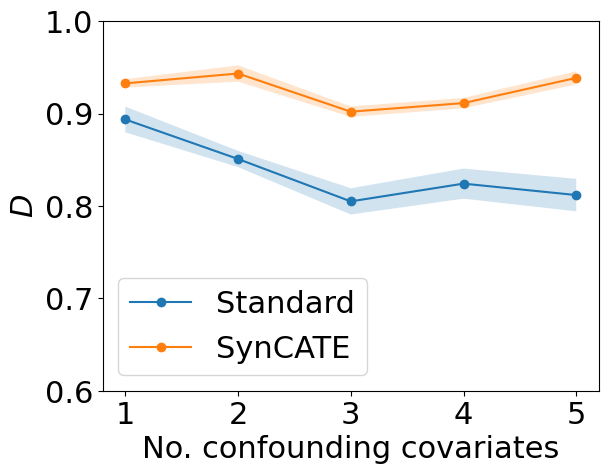

In [38]:
x = [1,2,3,4,5]
d_seq = conf_results[conf_results['method']=='seq_new'].groupby(['n_c']).mean()['d']
d_stand = conf_results[conf_results['method']=='standard'].groupby(['n_c']).mean()['d']

d_seq_std = conf_results[conf_results['method']=='seq_new'].groupby(['n_c']).std()['d'] / np.sqrt(10) * 1.96
d_stand_std = conf_results[conf_results['method']=='standard'].groupby(['n_c']).std()['d']/ np.sqrt(10) * 1.96

plt.rcParams.update({'font.size': 22})
plt.plot(x, d_stand, 'o-', label = 'Standard')
plt.plot(x, d_seq, 'o-', label = 'SynCATE')


plt.fill_between(x, d_stand - d_stand_std, d_stand + d_stand_std, alpha=0.2)
plt.fill_between(x, d_seq - d_seq_std, d_seq + d_seq_std, alpha=0.2)
plt.legend()
plt.xlabel('No. confounding covariates')
plt.ylabel('$D$')
plt.ylim([0.6,1])
plt.savefig('plots/confounding_complexity_plot.pdf', bbox_inches='tight')

What happens are num covariates increases?

In [300]:
X,y,w,p,t = simulate_treatment_setup(500, d=2, n_o=1, n_t=1)
X_df = pd.DataFrame(X)
y_df = pd.DataFrame(y, columns = ['y'])
w_df = pd.DataFrame(w, columns = ['w'])

d_real = pd.concat([X_df,w_df,y_df], axis=1)

In [301]:
test_cov_small = seq_test(d_real, 'ddpm', 'w', 'y', 3)

[2024-05-03T02:56:02.472509+0000][1207925][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-03T02:56:02.473777+0000][1207925][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-03T02:56:02.474460+0000][1207925][CRITICAL] module plugin_goggle load failed
Epoch: 100%|██████████| 1000/1000 [00:09<00:00, 105.83it/s, loss=1.08]
[2024-05-03T02:56:15.610555+0000][1207925][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-03T02:56:15.611305+0000][1207925][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-03T02:56:15.611758+0000][1207925][CRITICAL] module plugin_goggle load failed
Epoch: 100%|██████████| 1000/1000 [00:06<00:00, 165.80it/s, loss=0.471]
[2024-05-03T02:56:52.424485+0000][1207925][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no

In [302]:
test_cov_small.groupby('method').mean()

,f,d,u_pehe,u_policy,u_int
method,,,,,
seq_new,0.949355,0.948425,0.613462,0.756667,0.963520
standard,0.830259,0.914691,1.155762,0.506667,0.999829


What happens as number of predictive variables changes?

In [145]:
def predictive_insight(n, d, n_o, n_ts, gen, n_iter, save=False, fp=''):
    results = pd.DataFrame(columns=['method', 'f', 'c', 'd', 'u_pehe', 'u_policy', 'u_int', 'n_t'])
    for n_t in n_ts:
        X,y,w,p,t = simulate_treatment_setup(n, d=d, n_o=n_o, n_t=n_t)
        X_df = pd.DataFrame(X)
        y_df = pd.DataFrame(y, columns = ['y'])
        w_df = pd.DataFrame(w, columns = ['w'])
        d_real = pd.concat([X_df,w_df,y_df], axis=1)

        r = seq_test(d_real, gen, 'w', 'y', n_iter)
        r['n_t'] = n_t
        results = pd.concat([results, r])

        print(f'Tested n_t = {n_t}')

    if save:
        results.to_csv(fp, index=False)
        
    return results

In [146]:
pred_results = predictive_insight(1000, 10, 5, [0,1,2,3,4,5], 'ddpm', 10, save=True, fp = 'predictive_insight_average.csv')

[2024-05-13T13:13:09.302883+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T13:13:09.303474+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T13:13:09.303832+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm model


Epoch: 100%|██████████| 1000/1000 [00:12<00:00, 82.24it/s, loss=1.18]


Generating ddpm synthetic dataset


[2024-05-13T13:13:25.110268+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T13:13:25.110835+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T13:13:25.111166+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm covariate model


Epoch: 100%|██████████| 1000/1000 [00:08<00:00, 120.49it/s, loss=0.474]


Generating ddpm synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-13T13:17:22.828150+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T13:17:22.830469+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T13:17:22.831508+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm model


Epoch: 100%|██████████| 1000/1000 [00:11<00:00, 85.33it/s, loss=1.18]


Generating ddpm synthetic dataset


[2024-05-13T13:17:38.191124+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T13:17:38.191684+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T13:17:38.192037+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm covariate model


Epoch: 100%|██████████| 1000/1000 [00:08<00:00, 118.96it/s, loss=0.471]


Generating ddpm synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-13T13:21:35.748460+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T13:21:35.751101+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T13:21:35.752081+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm model


Epoch: 100%|██████████| 1000/1000 [00:11<00:00, 86.33it/s, loss=1.18]


Generating ddpm synthetic dataset


[2024-05-13T13:21:51.009463+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T13:21:51.010236+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T13:21:51.010587+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm covariate model


Epoch: 100%|██████████| 1000/1000 [00:08<00:00, 114.86it/s, loss=0.472]


Generating ddpm synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-13T13:25:42.899887+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T13:25:42.902463+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T13:25:42.903429+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm model


Epoch: 100%|██████████| 1000/1000 [00:11<00:00, 86.51it/s, loss=1.17]


Generating ddpm synthetic dataset


[2024-05-13T13:25:58.127779+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T13:25:58.128445+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T13:25:58.128862+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm covariate model


Epoch: 100%|██████████| 1000/1000 [00:08<00:00, 117.19it/s, loss=0.474]


Generating ddpm synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-13T13:29:53.900123+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T13:29:53.901824+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T13:29:53.902321+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm model


Epoch: 100%|██████████| 1000/1000 [00:11<00:00, 85.95it/s, loss=1.18]


Generating ddpm synthetic dataset


[2024-05-13T13:30:09.178669+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T13:30:09.179225+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T13:30:09.179569+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm covariate model


Epoch: 100%|██████████| 1000/1000 [00:08<00:00, 123.95it/s, loss=0.473]


Generating ddpm synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-13T13:34:01.687731+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T13:34:01.690222+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T13:34:01.691170+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm model


Epoch: 100%|██████████| 1000/1000 [00:11<00:00, 84.93it/s, loss=1.18]


Generating ddpm synthetic dataset


[2024-05-13T13:34:17.121012+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T13:34:17.121574+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T13:34:17.121947+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm covariate model


Epoch: 100%|██████████| 1000/1000 [00:08<00:00, 122.03it/s, loss=0.473]


Generating ddpm synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-13T13:38:22.445999+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T13:38:22.448295+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T13:38:22.449353+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm model


Epoch: 100%|██████████| 1000/1000 [00:11<00:00, 83.71it/s, loss=1.18]


Generating ddpm synthetic dataset


[2024-05-13T13:38:38.056449+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T13:38:38.057047+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T13:38:38.057398+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm covariate model


Epoch: 100%|██████████| 1000/1000 [00:08<00:00, 115.02it/s, loss=0.473]


Generating ddpm synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-13T13:42:29.462114+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T13:42:29.464461+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T13:42:29.465413+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm model


Epoch: 100%|██████████| 1000/1000 [00:11<00:00, 86.28it/s, loss=1.18]


Generating ddpm synthetic dataset


[2024-05-13T13:42:44.749209+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T13:42:44.750007+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T13:42:44.750457+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm covariate model


Epoch: 100%|██████████| 1000/1000 [00:08<00:00, 115.09it/s, loss=0.474]


Generating ddpm synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-13T13:46:36.321978+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T13:46:36.325878+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T13:46:36.326890+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm model


Epoch: 100%|██████████| 1000/1000 [00:12<00:00, 82.32it/s, loss=1.18]


Generating ddpm synthetic dataset


[2024-05-13T13:46:52.114846+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T13:46:52.115507+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T13:46:52.115922+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm covariate model


Epoch: 100%|██████████| 1000/1000 [00:08<00:00, 119.89it/s, loss=0.472]


Generating ddpm synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-13T13:50:43.175291+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T13:50:43.177357+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T13:50:43.178444+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm model


Epoch: 100%|██████████| 1000/1000 [00:11<00:00, 84.17it/s, loss=1.18]


Generating ddpm synthetic dataset


[2024-05-13T13:50:58.708355+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T13:50:58.708946+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T13:50:58.709384+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm covariate model


Epoch: 100%|██████████| 1000/1000 [00:08<00:00, 118.82it/s, loss=0.473]


Generating ddpm synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-13T13:54:55.230244+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T13:54:55.231143+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T13:54:55.231576+0000][4058068][CRITICAL] module plugin_goggle load failed


Tested n_t = 0
Fitting ddpm model


Epoch: 100%|██████████| 1000/1000 [00:11<00:00, 87.20it/s, loss=1.17]


Generating ddpm synthetic dataset


[2024-05-13T13:55:10.391803+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T13:55:10.392384+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T13:55:10.392747+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm covariate model


Epoch: 100%|██████████| 1000/1000 [00:08<00:00, 117.90it/s, loss=0.473]


Generating ddpm synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-13T13:59:28.714400+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T13:59:28.718005+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T13:59:28.719081+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm model


Epoch: 100%|██████████| 1000/1000 [00:11<00:00, 83.39it/s, loss=1.15]


Generating ddpm synthetic dataset


[2024-05-13T13:59:44.424708+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T13:59:44.425647+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T13:59:44.425992+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm covariate model


Epoch: 100%|██████████| 1000/1000 [00:08<00:00, 115.69it/s, loss=0.473]


Generating ddpm synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-13T14:04:03.760474+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T14:04:03.762669+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T14:04:03.763629+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm model


Epoch: 100%|██████████| 1000/1000 [00:11<00:00, 85.13it/s, loss=1.16]


Generating ddpm synthetic dataset


[2024-05-13T14:04:19.148487+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T14:04:19.149206+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T14:04:19.149593+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm covariate model


Epoch: 100%|██████████| 1000/1000 [00:08<00:00, 120.08it/s, loss=0.473]


Generating ddpm synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-13T14:08:41.439460+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T14:08:41.441803+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T14:08:41.442815+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm model


Epoch: 100%|██████████| 1000/1000 [00:12<00:00, 81.14it/s, loss=1.16]


Generating ddpm synthetic dataset


[2024-05-13T14:08:57.458232+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T14:08:57.458814+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T14:08:57.459383+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm covariate model


Epoch: 100%|██████████| 1000/1000 [00:08<00:00, 118.51it/s, loss=0.473]


Generating ddpm synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-13T14:13:10.601571+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T14:13:10.604309+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T14:13:10.605264+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm model


Epoch: 100%|██████████| 1000/1000 [00:11<00:00, 84.04it/s, loss=1.16]


Generating ddpm synthetic dataset


[2024-05-13T14:13:26.152581+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T14:13:26.153144+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T14:13:26.153498+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm covariate model


Epoch: 100%|██████████| 1000/1000 [00:08<00:00, 114.69it/s, loss=0.473]


Generating ddpm synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-13T14:17:39.876723+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T14:17:39.879173+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T14:17:39.880146+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm model


Epoch: 100%|██████████| 1000/1000 [00:11<00:00, 87.49it/s, loss=1.16]


Generating ddpm synthetic dataset


[2024-05-13T14:17:54.993437+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T14:17:54.994076+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T14:17:54.994735+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm covariate model


Epoch: 100%|██████████| 1000/1000 [00:08<00:00, 117.25it/s, loss=0.473]


Generating ddpm synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-13T14:22:11.077252+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T14:22:11.081688+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T14:22:11.082264+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm model


Epoch: 100%|██████████| 1000/1000 [00:11<00:00, 84.40it/s, loss=1.14]


Generating ddpm synthetic dataset


[2024-05-13T14:22:26.610356+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T14:22:26.611172+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T14:22:26.611633+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm covariate model


Epoch: 100%|██████████| 1000/1000 [00:08<00:00, 119.49it/s, loss=0.472]


Generating ddpm synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-13T14:26:43.654661+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T14:26:43.657716+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T14:26:43.658738+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm model


Epoch: 100%|██████████| 1000/1000 [00:11<00:00, 86.96it/s, loss=1.16]


Generating ddpm synthetic dataset


[2024-05-13T14:26:58.789568+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T14:26:58.790360+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T14:26:58.790763+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm covariate model


Epoch: 100%|██████████| 1000/1000 [00:08<00:00, 117.43it/s, loss=0.473]


Generating ddpm synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-13T14:31:17.907033+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T14:31:17.909624+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T14:31:17.910780+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm model


Epoch: 100%|██████████| 1000/1000 [00:11<00:00, 87.85it/s, loss=1.14]


Generating ddpm synthetic dataset


[2024-05-13T14:31:32.933792+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T14:31:32.934360+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T14:31:32.934718+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm covariate model


Epoch: 100%|██████████| 1000/1000 [00:08<00:00, 116.61it/s, loss=0.474]


Generating ddpm synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-13T14:35:52.758793+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T14:35:52.761820+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T14:35:52.762373+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm model


Epoch: 100%|██████████| 1000/1000 [00:11<00:00, 85.34it/s, loss=1.15]


Generating ddpm synthetic dataset


[2024-05-13T14:36:08.113403+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T14:36:08.114002+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T14:36:08.114376+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm covariate model


Epoch: 100%|██████████| 1000/1000 [00:08<00:00, 124.49it/s, loss=0.473]


Generating ddpm synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-13T14:40:31.836129+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T14:40:31.837040+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T14:40:31.837399+0000][4058068][CRITICAL] module plugin_goggle load failed


Tested n_t = 1
Fitting ddpm model


Epoch: 100%|██████████| 1000/1000 [00:11<00:00, 84.71it/s, loss=1.13]


Generating ddpm synthetic dataset


[2024-05-13T14:40:47.292009+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T14:40:47.292617+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T14:40:47.292981+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm covariate model


Epoch: 100%|██████████| 1000/1000 [00:08<00:00, 122.57it/s, loss=0.474]


Generating ddpm synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-13T14:45:09.136772+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T14:45:09.139376+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T14:45:09.140381+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm model


Epoch: 100%|██████████| 1000/1000 [00:11<00:00, 83.63it/s, loss=1.13]


Generating ddpm synthetic dataset


[2024-05-13T14:45:24.784427+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T14:45:24.785147+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T14:45:24.785523+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm covariate model


Epoch: 100%|██████████| 1000/1000 [00:08<00:00, 114.35it/s, loss=0.473]


Generating ddpm synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-13T14:49:49.486781+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T14:49:49.489199+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T14:49:49.490178+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm model


Epoch: 100%|██████████| 1000/1000 [00:11<00:00, 84.25it/s, loss=1.13]


Generating ddpm synthetic dataset


[2024-05-13T14:50:04.983504+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T14:50:04.984090+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T14:50:04.984441+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm covariate model


Epoch: 100%|██████████| 1000/1000 [00:08<00:00, 115.11it/s, loss=0.474]


Generating ddpm synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-13T14:54:41.274027+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T14:54:41.276365+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T14:54:41.277284+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm model


Epoch: 100%|██████████| 1000/1000 [00:11<00:00, 84.67it/s, loss=1.14]


Generating ddpm synthetic dataset


[2024-05-13T14:54:56.759517+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T14:54:56.760087+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T14:54:56.760378+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm covariate model


Epoch: 100%|██████████| 1000/1000 [00:08<00:00, 122.61it/s, loss=0.473]


Generating ddpm synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-13T14:59:28.569030+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T14:59:28.571306+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T14:59:28.572331+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm model


Epoch: 100%|██████████| 1000/1000 [00:11<00:00, 83.37it/s, loss=1.13]


Generating ddpm synthetic dataset


[2024-05-13T14:59:44.545526+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T14:59:44.546285+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T14:59:44.546670+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm covariate model


Epoch: 100%|██████████| 1000/1000 [00:08<00:00, 118.25it/s, loss=0.474]


Generating ddpm synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-13T15:04:05.123619+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T15:04:05.125792+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T15:04:05.126793+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm model


Epoch: 100%|██████████| 1000/1000 [00:11<00:00, 87.77it/s, loss=1.14]


Generating ddpm synthetic dataset


[2024-05-13T15:04:20.157337+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T15:04:20.158309+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T15:04:20.158741+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm covariate model


Epoch: 100%|██████████| 1000/1000 [00:08<00:00, 118.67it/s, loss=0.474]


Generating ddpm synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-13T15:08:51.882476+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T15:08:51.883795+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T15:08:51.884312+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm model


Epoch: 100%|██████████| 1000/1000 [00:11<00:00, 87.16it/s, loss=1.13]


Generating ddpm synthetic dataset


[2024-05-13T15:09:07.051095+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T15:09:07.051699+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T15:09:07.052051+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm covariate model


Epoch: 100%|██████████| 1000/1000 [00:08<00:00, 118.24it/s, loss=0.474]


Generating ddpm synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-13T15:13:40.088254+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T15:13:40.089494+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T15:13:40.093732+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm model


Epoch: 100%|██████████| 1000/1000 [00:11<00:00, 85.10it/s, loss=1.14]


Generating ddpm synthetic dataset


[2024-05-13T15:13:55.513566+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T15:13:55.514247+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T15:13:55.514604+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm covariate model


Epoch: 100%|██████████| 1000/1000 [00:08<00:00, 123.42it/s, loss=0.473]


Generating ddpm synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-13T15:18:24.449623+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T15:18:24.451526+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T15:18:24.452547+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm model


Epoch: 100%|██████████| 1000/1000 [00:11<00:00, 84.53it/s, loss=1.14]


Generating ddpm synthetic dataset


[2024-05-13T15:18:39.935003+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T15:18:39.935887+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T15:18:39.936334+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm covariate model


Epoch: 100%|██████████| 1000/1000 [00:08<00:00, 120.67it/s, loss=0.474]


Generating ddpm synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-13T15:23:16.658666+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T15:23:16.660777+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T15:23:16.661753+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm model


Epoch: 100%|██████████| 1000/1000 [00:11<00:00, 88.02it/s, loss=1.14]


Generating ddpm synthetic dataset


[2024-05-13T15:23:31.672481+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T15:23:31.673146+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T15:23:31.673506+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm covariate model


Epoch: 100%|██████████| 1000/1000 [00:08<00:00, 117.06it/s, loss=0.472]


Generating ddpm synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-13T15:27:57.502601+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T15:27:57.503446+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T15:27:57.503936+0000][4058068][CRITICAL] module plugin_goggle load failed


Tested n_t = 2
Fitting ddpm model


Epoch: 100%|██████████| 1000/1000 [00:11<00:00, 86.55it/s, loss=1.08]


Generating ddpm synthetic dataset


[2024-05-13T15:28:12.689096+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T15:28:12.689917+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T15:28:12.690276+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm covariate model


Epoch: 100%|██████████| 1000/1000 [00:08<00:00, 114.17it/s, loss=0.473]


Generating ddpm synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-13T15:33:10.330035+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T15:33:10.333643+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T15:33:10.334211+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm model


Epoch: 100%|██████████| 1000/1000 [00:11<00:00, 84.13it/s, loss=1.09]


Generating ddpm synthetic dataset


[2024-05-13T15:33:25.905464+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T15:33:25.906242+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T15:33:25.906688+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm covariate model


Epoch: 100%|██████████| 1000/1000 [00:08<00:00, 119.60it/s, loss=0.472]


Generating ddpm synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-13T15:38:18.669435+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T15:38:18.670335+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T15:38:18.670751+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm model


Epoch: 100%|██████████| 1000/1000 [00:11<00:00, 86.67it/s, loss=1.09]


Generating ddpm synthetic dataset


[2024-05-13T15:38:33.873579+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T15:38:33.874324+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T15:38:33.874864+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm covariate model


Epoch: 100%|██████████| 1000/1000 [00:08<00:00, 120.81it/s, loss=0.473]


Generating ddpm synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-13T15:43:22.030199+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T15:43:22.034341+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T15:43:22.035073+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm model


Epoch: 100%|██████████| 1000/1000 [00:11<00:00, 85.50it/s, loss=1.09]


Generating ddpm synthetic dataset


[2024-05-13T15:43:37.367738+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T15:43:37.368456+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T15:43:37.368998+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm covariate model


Epoch: 100%|██████████| 1000/1000 [00:08<00:00, 117.48it/s, loss=0.474]


Generating ddpm synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-13T15:48:09.917284+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T15:48:09.919648+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T15:48:09.920659+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm model


Epoch: 100%|██████████| 1000/1000 [00:12<00:00, 81.98it/s, loss=1.08]


Generating ddpm synthetic dataset


[2024-05-13T15:48:25.749302+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T15:48:25.750058+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T15:48:25.750386+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm covariate model


Epoch: 100%|██████████| 1000/1000 [00:08<00:00, 119.36it/s, loss=0.474]


Generating ddpm synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-13T15:53:08.170720+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T15:53:08.173419+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T15:53:08.174429+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm model


Epoch: 100%|██████████| 1000/1000 [00:12<00:00, 82.34it/s, loss=1.08]


Generating ddpm synthetic dataset


[2024-05-13T15:53:23.977191+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T15:53:23.978140+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T15:53:23.978502+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm covariate model


Epoch: 100%|██████████| 1000/1000 [00:08<00:00, 119.48it/s, loss=0.473]


Generating ddpm synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-13T15:58:07.278304+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T15:58:07.279595+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T15:58:07.280067+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm model


Epoch: 100%|██████████| 1000/1000 [00:11<00:00, 87.33it/s, loss=1.08]


Generating ddpm synthetic dataset


[2024-05-13T15:58:22.405629+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T15:58:22.406259+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T15:58:22.406591+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm covariate model


Epoch: 100%|██████████| 1000/1000 [00:08<00:00, 117.48it/s, loss=0.473]


Generating ddpm synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-13T16:03:08.634735+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T16:03:08.637434+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T16:03:08.638462+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm model


Epoch: 100%|██████████| 1000/1000 [00:11<00:00, 84.87it/s, loss=1.1] 


Generating ddpm synthetic dataset


[2024-05-13T16:03:24.077794+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T16:03:24.078569+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T16:03:24.079057+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm covariate model


Epoch: 100%|██████████| 1000/1000 [00:08<00:00, 115.18it/s, loss=0.473]


Generating ddpm synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-13T16:07:58.542967+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T16:07:58.545307+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T16:07:58.546357+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm model


Epoch: 100%|██████████| 1000/1000 [00:12<00:00, 81.68it/s, loss=1.08]


Generating ddpm synthetic dataset


[2024-05-13T16:08:14.465206+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T16:08:14.465951+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T16:08:14.466363+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm covariate model


Epoch: 100%|██████████| 1000/1000 [00:08<00:00, 119.78it/s, loss=0.473]


Generating ddpm synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-13T16:12:58.806256+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T16:12:58.808797+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T16:12:58.809881+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm model


Epoch: 100%|██████████| 1000/1000 [00:11<00:00, 84.46it/s, loss=1.09]


Generating ddpm synthetic dataset


[2024-05-13T16:13:14.288225+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T16:13:14.288971+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T16:13:14.289444+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm covariate model


Epoch: 100%|██████████| 1000/1000 [00:08<00:00, 121.78it/s, loss=0.474]


Generating ddpm synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-13T16:17:57.665162+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T16:17:57.665859+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T16:17:57.666274+0000][4058068][CRITICAL] module plugin_goggle load failed


Tested n_t = 3
Fitting ddpm model


Epoch: 100%|██████████| 1000/1000 [00:11<00:00, 86.83it/s, loss=1.04]


Generating ddpm synthetic dataset


[2024-05-13T16:18:12.803534+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T16:18:12.804260+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T16:18:12.804609+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm covariate model


Epoch: 100%|██████████| 1000/1000 [00:08<00:00, 116.71it/s, loss=0.472]


Generating ddpm synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-13T16:23:18.954980+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T16:23:18.957205+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T16:23:18.958242+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm model


Epoch: 100%|██████████| 1000/1000 [00:11<00:00, 84.34it/s, loss=1.04]


Generating ddpm synthetic dataset


[2024-05-13T16:23:34.450377+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T16:23:34.450937+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T16:23:34.451269+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm covariate model


Epoch: 100%|██████████| 1000/1000 [00:08<00:00, 116.21it/s, loss=0.473]


Generating ddpm synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-13T16:28:32.297296+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T16:28:32.299337+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T16:28:32.300340+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm model


Epoch: 100%|██████████| 1000/1000 [00:11<00:00, 85.24it/s, loss=1.03]


Generating ddpm synthetic dataset


[2024-05-13T16:28:47.672539+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T16:28:47.673372+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T16:28:47.673740+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm covariate model


Epoch: 100%|██████████| 1000/1000 [00:08<00:00, 122.44it/s, loss=0.473]


Generating ddpm synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-13T16:33:36.655445+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T16:33:36.656630+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T16:33:36.657128+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm model


Epoch: 100%|██████████| 1000/1000 [00:11<00:00, 85.48it/s, loss=1.03]


Generating ddpm synthetic dataset


[2024-05-13T16:33:52.027685+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T16:33:52.028235+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T16:33:52.028542+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm covariate model


Epoch: 100%|██████████| 1000/1000 [00:08<00:00, 123.11it/s, loss=0.473]


Generating ddpm synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-13T16:39:01.185667+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T16:39:01.187763+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T16:39:01.188823+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm model


Epoch: 100%|██████████| 1000/1000 [00:11<00:00, 83.48it/s, loss=1.03]


Generating ddpm synthetic dataset


[2024-05-13T16:39:16.841130+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T16:39:16.841703+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T16:39:16.842080+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm covariate model


Epoch: 100%|██████████| 1000/1000 [00:08<00:00, 114.59it/s, loss=0.472]


Generating ddpm synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-13T16:44:13.309400+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T16:44:13.310725+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T16:44:13.311107+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm model


Epoch: 100%|██████████| 1000/1000 [00:11<00:00, 87.48it/s, loss=1.03]


Generating ddpm synthetic dataset


[2024-05-13T16:44:28.408544+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T16:44:28.409148+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T16:44:28.409516+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm covariate model


Epoch: 100%|██████████| 1000/1000 [00:08<00:00, 118.79it/s, loss=0.473]


Generating ddpm synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-13T16:49:33.808393+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T16:49:33.809531+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T16:49:33.810062+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm model


Epoch: 100%|██████████| 1000/1000 [00:11<00:00, 85.32it/s, loss=1.04]


Generating ddpm synthetic dataset


[2024-05-13T16:49:49.190688+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T16:49:49.191226+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T16:49:49.191573+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm covariate model


Epoch: 100%|██████████| 1000/1000 [00:08<00:00, 122.75it/s, loss=0.473]


Generating ddpm synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-13T16:54:49.898861+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T16:54:49.901298+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T16:54:49.902344+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm model


Epoch: 100%|██████████| 1000/1000 [00:11<00:00, 84.62it/s, loss=1.03]


Generating ddpm synthetic dataset


[2024-05-13T16:55:05.361612+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T16:55:05.362409+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T16:55:05.362810+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm covariate model


Epoch: 100%|██████████| 1000/1000 [00:08<00:00, 121.71it/s, loss=0.472]


Generating ddpm synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-13T17:00:21.008582+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T17:00:21.011218+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T17:00:21.012144+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm model


Epoch: 100%|██████████| 1000/1000 [00:11<00:00, 86.14it/s, loss=1.03]


Generating ddpm synthetic dataset


[2024-05-13T17:00:36.317561+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T17:00:36.318437+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T17:00:36.318859+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm covariate model


Epoch: 100%|██████████| 1000/1000 [00:08<00:00, 115.75it/s, loss=0.472]


Generating ddpm synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-13T17:05:35.718800+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T17:05:35.721386+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T17:05:35.722343+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm model


Epoch: 100%|██████████| 1000/1000 [00:11<00:00, 86.01it/s, loss=1.04]


Generating ddpm synthetic dataset


[2024-05-13T17:05:51.032246+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T17:05:51.033011+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T17:05:51.033441+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm covariate model


Epoch: 100%|██████████| 1000/1000 [00:08<00:00, 114.35it/s, loss=0.474]


Generating ddpm synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-13T17:10:45.489514+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T17:10:45.490517+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T17:10:45.490990+0000][4058068][CRITICAL] module plugin_goggle load failed


Tested n_t = 4
Fitting ddpm model


Epoch: 100%|██████████| 1000/1000 [00:11<00:00, 84.78it/s, loss=1.01]


Generating ddpm synthetic dataset


[2024-05-13T17:11:00.922427+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T17:11:00.923180+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T17:11:00.923535+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm covariate model


Epoch: 100%|██████████| 1000/1000 [00:08<00:00, 121.13it/s, loss=0.474]


Generating ddpm synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-13T17:15:54.822667+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T17:15:54.823410+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T17:15:54.823840+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm model


Epoch: 100%|██████████| 1000/1000 [00:11<00:00, 88.32it/s, loss=0.991]


Generating ddpm synthetic dataset


[2024-05-13T17:16:09.758309+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T17:16:09.758866+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T17:16:09.759217+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm covariate model


Epoch: 100%|██████████| 1000/1000 [00:08<00:00, 123.14it/s, loss=0.472]


Generating ddpm synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-13T17:21:11.602823+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T17:21:11.605404+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T17:21:11.606402+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm model


Epoch: 100%|██████████| 1000/1000 [00:11<00:00, 83.42it/s, loss=1.01]


Generating ddpm synthetic dataset


[2024-05-13T17:21:27.263540+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T17:21:27.264643+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T17:21:27.265023+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm covariate model


Epoch: 100%|██████████| 1000/1000 [00:08<00:00, 113.93it/s, loss=0.473]


Generating ddpm synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-13T17:26:42.908983+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T17:26:42.911472+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T17:26:42.912448+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm model


Epoch: 100%|██████████| 1000/1000 [00:11<00:00, 84.94it/s, loss=1.01]


Generating ddpm synthetic dataset


[2024-05-13T17:26:58.309053+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T17:26:58.309825+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T17:26:58.310373+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm covariate model


Epoch: 100%|██████████| 1000/1000 [00:08<00:00, 119.66it/s, loss=0.472]


Generating ddpm synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-13T17:31:57.932607+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T17:31:57.935297+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T17:31:57.936250+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm model


Epoch: 100%|██████████| 1000/1000 [00:11<00:00, 83.46it/s, loss=1]   


Generating ddpm synthetic dataset


[2024-05-13T17:32:13.587403+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T17:32:13.588110+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T17:32:13.588443+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm covariate model


Epoch: 100%|██████████| 1000/1000 [00:08<00:00, 120.22it/s, loss=0.473]


Generating ddpm synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-13T17:37:22.571364+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T17:37:22.573317+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T17:37:22.574340+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm model


Epoch: 100%|██████████| 1000/1000 [00:11<00:00, 84.36it/s, loss=1.01]


Generating ddpm synthetic dataset


[2024-05-13T17:37:38.078472+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T17:37:38.079427+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T17:37:38.079942+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm covariate model


Epoch: 100%|██████████| 1000/1000 [00:08<00:00, 117.04it/s, loss=0.474]


Generating ddpm synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-13T17:42:39.273795+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T17:42:39.276297+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T17:42:39.277266+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm model


Epoch: 100%|██████████| 1000/1000 [00:11<00:00, 86.03it/s, loss=1]   


Generating ddpm synthetic dataset


[2024-05-13T17:42:54.550099+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T17:42:54.550852+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T17:42:54.551333+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm covariate model


Epoch: 100%|██████████| 1000/1000 [00:08<00:00, 116.75it/s, loss=0.474]


Generating ddpm synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-13T17:47:58.937200+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T17:47:58.939447+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T17:47:58.940439+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm model


Epoch: 100%|██████████| 1000/1000 [00:12<00:00, 81.47it/s, loss=1]   


Generating ddpm synthetic dataset


[2024-05-13T17:48:14.899312+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T17:48:14.899923+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T17:48:14.900361+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm covariate model


Epoch: 100%|██████████| 1000/1000 [00:08<00:00, 119.51it/s, loss=0.473]


Generating ddpm synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-13T17:53:29.671705+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T17:53:29.674188+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T17:53:29.675191+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm model


Epoch: 100%|██████████| 1000/1000 [00:12<00:00, 82.98it/s, loss=1]   


Generating ddpm synthetic dataset


[2024-05-13T17:53:45.350841+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T17:53:45.351597+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T17:53:45.352053+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm covariate model


Epoch: 100%|██████████| 1000/1000 [00:08<00:00, 122.30it/s, loss=0.472]


Generating ddpm synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-13T17:58:43.507080+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T17:58:43.509288+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T17:58:43.510253+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm model


Epoch: 100%|██████████| 1000/1000 [00:11<00:00, 88.26it/s, loss=1.01]


Generating ddpm synthetic dataset


[2024-05-13T17:58:58.468580+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T17:58:58.469188+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T17:58:58.469553+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm covariate model


Epoch: 100%|██████████| 1000/1000 [00:08<00:00, 118.64it/s, loss=0.471]


Generating ddpm synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs
Tested n_t = 5


In [26]:
pred_results = pd.read_csv('predictive_insight_average.csv')

In [29]:
pred_results = pred_results[pred_results['n_t'] != 0]

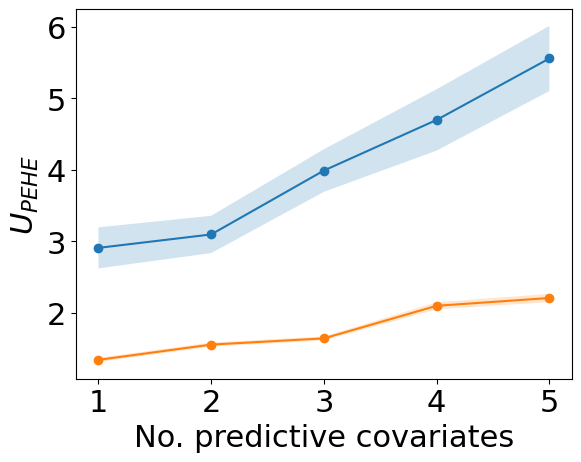

In [41]:
x = [1,2,3,4,5]
u_seq = pred_results[pred_results['method']=='seq_new'].groupby(['n_t']).mean()['u_pehe']
u_stand = pred_results[pred_results['method']=='standard'].groupby(['n_t']).mean()['u_pehe']

u_seq_std = pred_results[pred_results['method']=='seq_new'].groupby(['n_t']).std()['u_pehe'] / np.sqrt(10) * 1.96
u_stand_std = pred_results[pred_results['method']=='standard'].groupby(['n_t']).std()['u_pehe']/ np.sqrt(10) * 1.96


plt.plot(x, u_stand, 'o-', label = 'Standard')
plt.plot(x, u_seq, 'o-', label = 'SynCATE')


plt.fill_between(x, u_stand - u_stand_std, u_stand + u_stand_std, alpha=0.2)
plt.fill_between(x, u_seq - u_seq_std, u_seq + u_seq_std, alpha=0.2)
#plt.legend()
plt.xlabel('No. predictive covariates')
plt.ylabel('$U_{PEHE}$')
plt.savefig('plots/CATE_complexity_plot.pdf', bbox_inches='tight')

## Privacy

In [35]:
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.data =X
        self.labels = y
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return torch.tensor(self.data[idx], dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.float32)

In [ ]:
# do privacy on simulated datasets to make it easier/faster

In [153]:
def privacy_comparison(real, gen, treatment_col, outcome_col, delta, epsilons, n_iter, save=False, fp=''):
    results = pd.DataFrame(columns=['method', 'epsilon', 'f', 'c', 'd', 'avg_u_pehe'])
    n_units = len(real.drop([treatment_col, outcome_col], axis=1).columns)
    for epsilon in epsilons:
        for _ in range(n_iter):
            synth = generate_standard(real, gen, private=True, epsilon=epsilon, delta=delta)

            results.loc[len(results)] = ['standard', epsilon, evaluate_f(real, synth, treatment_col, outcome_col), evaluate_c(real, synth, treatment_col, outcome_col), 
                                     evaluate_d(real, synth, treatment_col, outcome_col), evaluate_average_u_pehe(real, synth, treatment_col, outcome_col, n_units)]

            synth_seq = generate_sequentially(real, gen, treatment_col, outcome_col, private=True, epsilon = epsilon/3, delta=delta/3)

            results.loc[len(results)] = ['sequential', epsilon, evaluate_f(real, synth_seq, treatment_col, outcome_col), evaluate_c(real, synth_seq, treatment_col, outcome_col), 
                                     evaluate_d(real, synth_seq, treatment_col, outcome_col), evaluate_average_u_pehe(real, synth_seq, treatment_col, outcome_col, n_units)]
    
            if save:
                print('saving results')
                results.to_csv(fp, index=False)
    return results

In [235]:
X,y,w,p,t = simulate_treatment_setup(1000, d=5, n_t=3, n_c=2)
X_df = pd.DataFrame(X)
y_df = pd.DataFrame(y, columns = ['y'])
w_df = pd.DataFrame(w, columns = ['w'])
d_real = pd.concat([X_df,w_df,y_df], axis=1)

In [237]:
test = privacy_comparison(d_real, 'dpgan', 'w', 'y', delta = 1e-3, epsilons = [1], n_iter = 10, save=True, fp ='simulated_privacy_dpgan_more_runs.csv')

[2024-05-14T10:57:17.521831+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T10:57:17.523128+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T10:57:17.523486+0000][130783][CRITICAL] module plugin_goggle load failed


Fitting dpgan model


 25%|██▍       | 499/2000 [00:46<02:21, 10.62it/s]


Generating dpgan synthetic dataset


[2024-05-14T10:59:13.255637+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T10:59:13.256644+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T10:59:13.257064+0000][130783][CRITICAL] module plugin_goggle load failed


Fitting dpgan covariate model


 22%|██▏       | 449/2000 [00:39<02:17, 11.29it/s]


Generating dpgan synthetic covariates
Fitting propensity model
Generating propensities
Fitting private CATE learner
Generating POs


[2024-05-14T11:01:13.973150+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T11:01:13.974006+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T11:01:13.974407+0000][130783][CRITICAL] module plugin_goggle load failed


saving results
Fitting dpgan model


 15%|█▍        | 299/2000 [00:28<02:42, 10.49it/s]


Generating dpgan synthetic dataset


[2024-05-14T11:02:54.124679+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T11:02:54.125972+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T11:02:54.126333+0000][130783][CRITICAL] module plugin_goggle load failed


Fitting dpgan covariate model


 25%|██▍       | 499/2000 [00:43<02:11, 11.40it/s]


Generating dpgan synthetic covariates
Fitting propensity model
Generating propensities
Fitting private CATE learner
Generating POs


ValueError: Expected more than 1 value per channel when training, got input size torch.Size([1, 100])

In [261]:
normalized=(jobs-jobs.mean())/jobs.std()

In [263]:
normalized_jobs = jobs.copy()
normalized_jobs['age'] = normalized['age']
normalized_jobs['education'] = normalized['education']
normalized_jobs['re75'] = normalized['re75']
normalized_jobs['re78'] = normalized['re78']

In [284]:
test_2 = privacy_comparison(normalized_jobs, 'dpgan', 'training', 're78', delta = 1e-3, epsilons = [50], n_iter = 10, save=True, fp ='jobs_privacy_dpgan_normalized_100.csv')

[2024-05-14T23:34:22.891253+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T23:34:22.892272+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T23:34:22.892762+0000][130783][CRITICAL] module plugin_goggle load failed


Fitting dpgan model


 15%|█▍        | 299/2000 [00:25<02:26, 11.58it/s]


Generating dpgan synthetic dataset


[2024-05-14T23:35:55.788155+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T23:35:55.789541+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T23:35:55.790034+0000][130783][CRITICAL] module plugin_goggle load failed


Fitting dpgan covariate model


 32%|███▏      | 649/2000 [00:51<01:47, 12.61it/s]


Generating dpgan synthetic covariates
Fitting propensity model
Generating propensities
Fitting private CATE learner
Generating POs


[2024-05-14T23:37:59.540645+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T23:37:59.541360+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T23:37:59.541779+0000][130783][CRITICAL] module plugin_goggle load failed


saving results
Fitting dpgan model


 20%|█▉        | 399/2000 [00:35<02:21, 11.34it/s]


Generating dpgan synthetic dataset


[2024-05-14T23:39:29.660220+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T23:39:29.661585+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T23:39:29.661945+0000][130783][CRITICAL] module plugin_goggle load failed


Fitting dpgan covariate model


 25%|██▍       | 499/2000 [00:39<01:57, 12.76it/s]


Generating dpgan synthetic covariates
Fitting propensity model
Generating propensities
Fitting private CATE learner
Generating POs


[2024-05-14T23:41:24.388742+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T23:41:24.389334+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T23:41:24.389711+0000][130783][CRITICAL] module plugin_goggle load failed


saving results
Fitting dpgan model


 37%|███▋      | 749/2000 [01:05<01:49, 11.39it/s]


Generating dpgan synthetic dataset


[2024-05-14T23:43:19.649674+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T23:43:19.650701+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T23:43:19.651093+0000][130783][CRITICAL] module plugin_goggle load failed


Fitting dpgan covariate model


 22%|██▏       | 449/2000 [00:35<02:01, 12.77it/s]


Generating dpgan synthetic covariates
Fitting propensity model
Generating propensities
Fitting private CATE learner
Generating POs


[2024-05-14T23:45:08.678693+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T23:45:08.679493+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T23:45:08.679919+0000][130783][CRITICAL] module plugin_goggle load failed


saving results
Fitting dpgan model


 25%|██▍       | 499/2000 [00:43<02:09, 11.60it/s]


Generating dpgan synthetic dataset


[2024-05-14T23:47:00.029130+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T23:47:00.030127+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T23:47:00.030459+0000][130783][CRITICAL] module plugin_goggle load failed


Fitting dpgan covariate model


 27%|██▋       | 549/2000 [00:43<01:54, 12.71it/s]


Generating dpgan synthetic covariates
Fitting propensity model
Generating propensities
Fitting private CATE learner
Generating POs


[2024-05-14T23:48:55.452475+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T23:48:55.453218+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T23:48:55.453604+0000][130783][CRITICAL] module plugin_goggle load failed


saving results
Fitting dpgan model


 17%|█▋        | 349/2000 [00:29<02:21, 11.66it/s]


Generating dpgan synthetic dataset


[2024-05-14T23:50:17.383815+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T23:50:17.384885+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T23:50:17.385216+0000][130783][CRITICAL] module plugin_goggle load failed


Fitting dpgan covariate model


 22%|██▏       | 449/2000 [00:35<02:01, 12.72it/s]


Generating dpgan synthetic covariates
Fitting propensity model
Generating propensities
Fitting private CATE learner
Generating POs


[2024-05-14T23:52:06.251715+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T23:52:06.252466+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T23:52:06.252860+0000][130783][CRITICAL] module plugin_goggle load failed


saving results
Fitting dpgan model


 17%|█▋        | 349/2000 [00:30<02:22, 11.58it/s]


Generating dpgan synthetic dataset


[2024-05-14T23:53:30.443031+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T23:53:30.444040+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T23:53:30.444502+0000][130783][CRITICAL] module plugin_goggle load failed


Fitting dpgan covariate model


 20%|█▉        | 399/2000 [00:31<02:08, 12.47it/s]


Generating dpgan synthetic covariates
Fitting propensity model
Generating propensities
Fitting private CATE learner
Generating POs


[2024-05-14T23:55:14.173042+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T23:55:14.173807+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T23:55:14.174400+0000][130783][CRITICAL] module plugin_goggle load failed


saving results
Fitting dpgan model


 25%|██▍       | 499/2000 [00:43<02:10, 11.54it/s]


Generating dpgan synthetic dataset


Bad pipe message: %s [b'"_k\xa4\x15\x0e\x1f\x07l\xf8\xe2\xf2\xcc\xbfd\x91\xdfb hW\xe0\xc2\xbd\xf4\x9f8\x13W\xf2\xc7\xca\'\xd1\xb2MZ\x9a\x84\xb7\xa8I\x18t\x98\x1d\xf6^\x9d\x0cs\x00\x08\x13\x02\x13\x03\x13\x01\x00\xff\x01\x00\x00\x8f\x00\x00\x00\x0e\x00\x0c\x00\x00\t127.0.0.1\x00\x0b\x00\x04\x03\x00\x01\x02\x00\n\x00\x0c\x00\n\x00\x1d\x00\x17\x00\x1e\x00\x19\x00\x18\x00#\x00\x00\x00\x16\x00\x00\x00\x17\x00\x00\x00\r\x00\x1e\x00\x1c\x04\x03\x05\x03\x06\x03\x08\x07\x08\x08\x08\t\x08\n\x08\x0b\x08\x04\x08\x05\x08\x06\x04\x01\x05\x01\x06\x01\x00+\x00\x03\x02', b'\x00-']
Bad pipe message: %s [b'\xc6\xd0q9\x15']
Bad pipe message: %s [b"k\xf69\xf4\x1f\x93\x08\x83~\x87!\xd4B\xb5\xdc\x9cz'\x00\x00\xa6\xc0,\xc00\x00\xa3\x00\x9f\xcc\xa9\xcc\xa8\xcc\xaa\xc0\xaf\xc0\xad\xc0\xa3\xc0\x9f\xc0]\xc0a\xc0W\xc0S\xc0+\xc0/\x00\xa2\x00\x9e\xc0\xae\xc0\xac\xc0\xa2\xc0\x9e", b"\xc0`\xc0V\xc0R\xc0$\xc0(\x00k\x00j\xc0s\xc0w\x00\xc4\x00\xc3\xc0#\xc0'\x00g\x00@\xc0r\xc0v\x00\xbe\x00\xbd\xc0\n\xc0\x14\x009\x008\x00\

Fitting dpgan covariate model


  0%|          | 0/2000 [00:00<?, ?it/s]


RuntimeError: Mismatch in shape: grad_output[0] has a shape of torch.Size([1]) and output[0] has a shape of torch.Size([]).

In [277]:
test = privacy_comparison(normalized_jobs, 'dpgan', 'training', 're78', delta = 1e-3, epsilons = [15,20], n_iter = 10, save=True, fp ='jobs_privacy_dpgan_normalized_2.csv')

[2024-05-14T12:21:31.114264+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T12:21:31.115572+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T12:21:31.116002+0000][130783][CRITICAL] module plugin_goggle load failed


Fitting dpgan model


 25%|██▍       | 499/2000 [00:40<02:00, 12.46it/s]


Generating dpgan synthetic dataset


[2024-05-14T12:22:42.613998+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T12:22:42.615367+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T12:22:42.615738+0000][130783][CRITICAL] module plugin_goggle load failed


Fitting dpgan covariate model


 25%|██▍       | 499/2000 [00:38<01:54, 13.07it/s]


Generating dpgan synthetic covariates
Fitting propensity model
Generating propensities
Fitting private CATE learner
Generating POs


[2024-05-14T12:24:09.461483+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T12:24:09.462354+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T12:24:09.462834+0000][130783][CRITICAL] module plugin_goggle load failed


saving results
Fitting dpgan model


 35%|███▍      | 699/2000 [00:56<01:44, 12.39it/s]


Generating dpgan synthetic dataset


[2024-05-14T12:25:43.682863+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T12:25:43.684107+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T12:25:43.684500+0000][130783][CRITICAL] module plugin_goggle load failed


Fitting dpgan covariate model


 17%|█▋        | 349/2000 [00:26<02:05, 13.16it/s]


Generating dpgan synthetic covariates
Fitting propensity model
Generating propensities
Fitting private CATE learner
Generating POs


[2024-05-14T12:26:59.364283+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T12:26:59.365035+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T12:26:59.365446+0000][130783][CRITICAL] module plugin_goggle load failed


saving results
Fitting dpgan model


 32%|███▏      | 649/2000 [00:51<01:47, 12.52it/s]


Generating dpgan synthetic dataset


[2024-05-14T12:28:40.174611+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T12:28:40.175623+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T12:28:40.176110+0000][130783][CRITICAL] module plugin_goggle load failed


Fitting dpgan covariate model


 17%|█▋        | 349/2000 [00:27<02:10, 12.64it/s]


Generating dpgan synthetic covariates
Fitting propensity model
Generating propensities
Fitting private CATE learner
Generating POs


[2024-05-14T12:29:56.430598+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T12:29:56.431381+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T12:29:56.431772+0000][130783][CRITICAL] module plugin_goggle load failed


saving results
Fitting dpgan model


 17%|█▋        | 349/2000 [00:28<02:12, 12.46it/s]


Generating dpgan synthetic dataset


[2024-05-14T12:30:59.898808+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T12:30:59.900002+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T12:30:59.900398+0000][130783][CRITICAL] module plugin_goggle load failed


Fitting dpgan covariate model


 20%|█▉        | 399/2000 [00:30<02:03, 12.99it/s]


Generating dpgan synthetic covariates
Fitting propensity model
Generating propensities
Fitting private CATE learner
Generating POs


[2024-05-14T12:32:22.676669+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T12:32:22.677521+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T12:32:22.677956+0000][130783][CRITICAL] module plugin_goggle load failed


saving results
Fitting dpgan model


 15%|█▍        | 299/2000 [00:24<02:17, 12.37it/s]


Generating dpgan synthetic dataset


[2024-05-14T12:33:18.518686+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T12:33:18.519706+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T12:33:18.520047+0000][130783][CRITICAL] module plugin_goggle load failed


Fitting dpgan covariate model


 20%|█▉        | 399/2000 [00:30<02:03, 12.98it/s]


Generating dpgan synthetic covariates
Fitting propensity model
Generating propensities
Fitting private CATE learner
Generating POs


[2024-05-14T12:34:38.540197+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T12:34:38.540938+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T12:34:38.541313+0000][130783][CRITICAL] module plugin_goggle load failed


saving results
Fitting dpgan model


 25%|██▍       | 499/2000 [00:40<02:01, 12.35it/s]


Generating dpgan synthetic dataset


[2024-05-14T12:36:04.645233+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T12:36:04.646621+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T12:36:04.647403+0000][130783][CRITICAL] module plugin_goggle load failed


Fitting dpgan covariate model


 27%|██▋       | 549/2000 [00:42<01:51, 12.99it/s]


Generating dpgan synthetic covariates
Fitting propensity model
Generating propensities
Fitting private CATE learner
Generating POs


[2024-05-14T12:37:33.616348+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T12:37:33.617215+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T12:37:33.617709+0000][130783][CRITICAL] module plugin_goggle load failed


saving results
Fitting dpgan model


 20%|█▉        | 399/2000 [00:32<02:08, 12.46it/s]


Generating dpgan synthetic dataset


[2024-05-14T12:38:42.061274+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T12:38:42.062646+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T12:38:42.063170+0000][130783][CRITICAL] module plugin_goggle load failed


Fitting dpgan covariate model


 27%|██▋       | 549/2000 [00:43<01:55, 12.61it/s]


Generating dpgan synthetic covariates
Fitting propensity model
Generating propensities
Fitting private CATE learner
Generating POs


[2024-05-14T12:40:12.954854+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T12:40:12.955472+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T12:40:12.955901+0000][130783][CRITICAL] module plugin_goggle load failed


saving results
Fitting dpgan model


 17%|█▋        | 349/2000 [00:27<02:12, 12.48it/s]


Generating dpgan synthetic dataset


[2024-05-14T12:41:27.543826+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T12:41:27.544853+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T12:41:27.545215+0000][130783][CRITICAL] module plugin_goggle load failed


Fitting dpgan covariate model


 17%|█▋        | 349/2000 [00:26<02:07, 12.97it/s]


Generating dpgan synthetic covariates
Fitting propensity model
Generating propensities
Fitting private CATE learner
Generating POs


[2024-05-14T12:42:44.090210+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T12:42:44.090770+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T12:42:44.091138+0000][130783][CRITICAL] module plugin_goggle load failed


saving results
Fitting dpgan model


 45%|████▍     | 899/2000 [01:12<01:28, 12.42it/s]


Generating dpgan synthetic dataset


[2024-05-14T12:44:43.937966+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T12:44:43.938631+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T12:44:43.938975+0000][130783][CRITICAL] module plugin_goggle load failed


Fitting dpgan covariate model


 22%|██▏       | 449/2000 [00:34<01:59, 13.01it/s]


Generating dpgan synthetic covariates
Fitting propensity model
Generating propensities
Fitting private CATE learner
Generating POs


[2024-05-14T12:46:06.587769+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T12:46:06.588348+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T12:46:06.588724+0000][130783][CRITICAL] module plugin_goggle load failed


saving results
Fitting dpgan model


 30%|██▉       | 599/2000 [00:47<01:52, 12.49it/s]


Generating dpgan synthetic dataset


[2024-05-14T12:47:26.924360+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T12:47:26.925030+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T12:47:26.925386+0000][130783][CRITICAL] module plugin_goggle load failed


Fitting dpgan covariate model


 17%|█▋        | 349/2000 [00:26<02:07, 13.00it/s]


Generating dpgan synthetic covariates
Fitting propensity model
Generating propensities
Fitting private CATE learner
Generating POs


[2024-05-14T12:48:42.733540+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T12:48:42.734466+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T12:48:42.734930+0000][130783][CRITICAL] module plugin_goggle load failed


saving results
Fitting dpgan model


 20%|█▉        | 399/2000 [00:32<02:08, 12.42it/s]


Generating dpgan synthetic dataset


[2024-05-14T12:49:52.279155+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T12:49:52.280389+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T12:49:52.281034+0000][130783][CRITICAL] module plugin_goggle load failed


Fitting dpgan covariate model


 17%|█▋        | 349/2000 [00:27<02:08, 12.88it/s]


Generating dpgan synthetic covariates
Fitting propensity model
Generating propensities
Fitting private CATE learner
Generating POs


[2024-05-14T12:51:11.976489+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T12:51:11.977424+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T12:51:11.977946+0000][130783][CRITICAL] module plugin_goggle load failed


saving results
Fitting dpgan model


 17%|█▋        | 349/2000 [00:28<02:16, 12.08it/s]


Generating dpgan synthetic dataset


ValueError: Expected more than 1 value per channel when training, got input size torch.Size([1, 100])

In [239]:
test = pd.read_csv('simulated_privacy_dpgan_more_runs.csv')

In [240]:
test

,method,epsilon,f,c,d,avg_u_pehe
0,standard,1.5,0.772533,0.206000,0.455955,4.700255
1,sequential,1.5,0.375800,0.433667,0.415196,3.590751


In [50]:
results_comb = pd.read_csv('simulated_privacy_dpgan_combined.csv')
#results_comb = pd.read_csv('jobs_privacy_dpgan_normalized.csv')

In [290]:
test = pd.read_csv('jobs_privacy_dpgan_normalized_100.csv')

In [291]:
results_comb = pd.concat([results_comb, test])

In [234]:
#results_comb.to_csv('simulated_privacy_dpgan_combined.csv', index=False)

In [310]:
results_comb = results_comb.reset_index(drop=True)

In [313]:
results_comb = results_comb.drop([60,61,62,63])

In [51]:
results_comb.groupby('epsilon').count()

,method,f,c,d,avg_u_pehe
epsilon,,,,,
1,20,20,20,20,20
2,20,20,20,20,20
3,20,20,20,20,20
4,20,20,20,20,20
5,20,20,20,20,20
10,20,20,20,20,20
15,20,20,20,20,20


In [53]:
results_standard = results_comb[results_comb['method']=='standard']

In [54]:
results_seq = results_comb[results_comb['method']=='sequential']

In [55]:
x = [1,2,3,4,5,10,15]
d_stand = results_standard.groupby('epsilon').mean()['d']
d_seq = results_seq.groupby('epsilon').mean()['d']
f_stand = results_standard.groupby('epsilon').mean()['f']
f_seq = results_seq.groupby('epsilon').mean()['f']
c_stand = results_standard.groupby('epsilon').mean()['c']
c_seq = results_seq.groupby('epsilon').mean()['c']
u_stand = results_standard.groupby('epsilon').mean()['avg_u_pehe']
u_seq = results_seq.groupby('epsilon').mean()['avg_u_pehe']


d_stand_std = results_standard.groupby('epsilon').std()['d'] / np.sqrt(10) * 1.96
d_seq_std = results_seq.groupby('epsilon').std()['d']/ np.sqrt(10)* 1.96
f_stand_std = results_standard.groupby('epsilon').std()['f']/ np.sqrt(10)* 1.96
f_seq_std = results_seq.groupby('epsilon').std()['f']/ np.sqrt(10)* 1.96
c_stand_std = results_standard.groupby('epsilon').std()['c']/ np.sqrt(10)* 1.96
c_seq_std = results_seq.groupby('epsilon').std()['c']/ np.sqrt(10)* 1.96
u_stand_std = results_standard.groupby('epsilon').std()['avg_u_pehe']/ np.sqrt(10)* 1.96
u_seq_std = results_seq.groupby('epsilon').std()['avg_u_pehe']/ np.sqrt(10)* 1.96

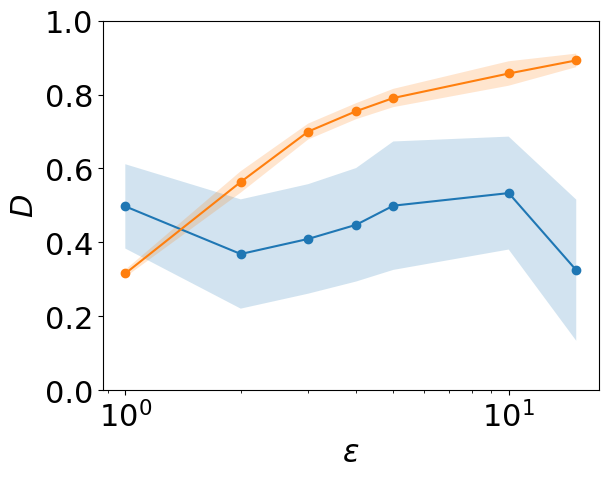

In [57]:
plt.plot(x, d_stand, 'o-', label = 'Standard')
plt.plot(x, d_seq, 'o-', label = 'Sequential')
plt.fill_between(x, d_stand - d_stand_std, d_stand + d_stand_std, alpha=0.2)
plt.fill_between(x, d_seq - d_seq_std, d_seq + d_seq_std, alpha=0.2)
#plt.legend()
plt.ylim([0,1])
plt.ylabel('$D$')
plt.xlabel('$\epsilon$')
plt.xscale('log')
plt.savefig('plots/D_with_epsilon.pdf', bbox_inches='tight')

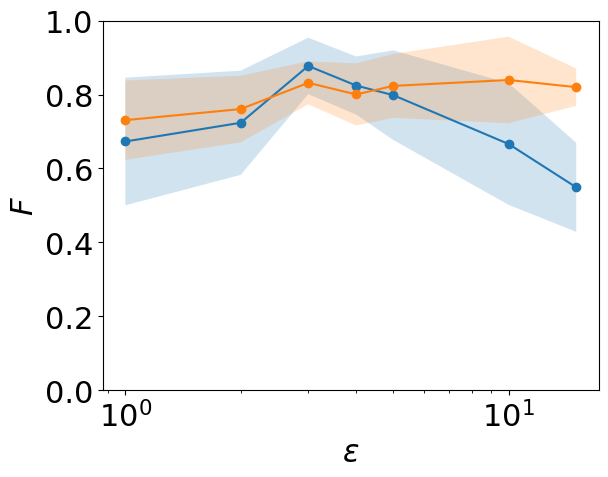

In [58]:
plt.plot(x, f_stand, 'o-', label = 'Standard')
plt.plot(x, f_seq, 'o-', label = 'Sequential')
plt.fill_between(x, f_stand - f_stand_std, f_stand + f_stand_std, alpha=0.2)
plt.fill_between(x, f_seq - f_seq_std, f_seq + f_seq_std, alpha=0.2)
#plt.legend()
plt.ylim([0,1])
plt.ylabel('$F$')
plt.xlabel('$\epsilon$')
plt.xscale('log')
plt.savefig('plots/F_with_epsilon.pdf', bbox_inches='tight')

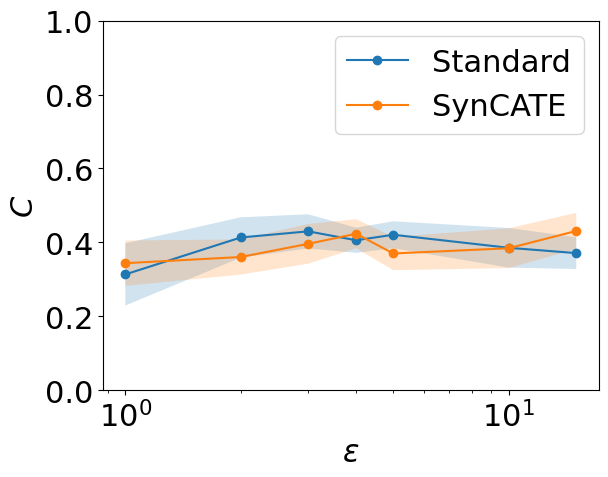

In [61]:
plt.plot(x, c_stand, 'o-', label = 'Standard')
plt.plot(x, c_seq, 'o-', label = 'SynCATE')
plt.fill_between(x, c_stand - c_stand_std, c_stand + c_stand_std, alpha=0.2)
plt.fill_between(x, c_seq - c_seq_std, c_seq + c_seq_std, alpha=0.2)
plt.legend()
plt.ylim([0,1])
plt.ylabel('$C$')
plt.xlabel('$\epsilon$')
plt.xscale('log')
plt.savefig('plots/C_with_epsilon.pdf', bbox_inches='tight')

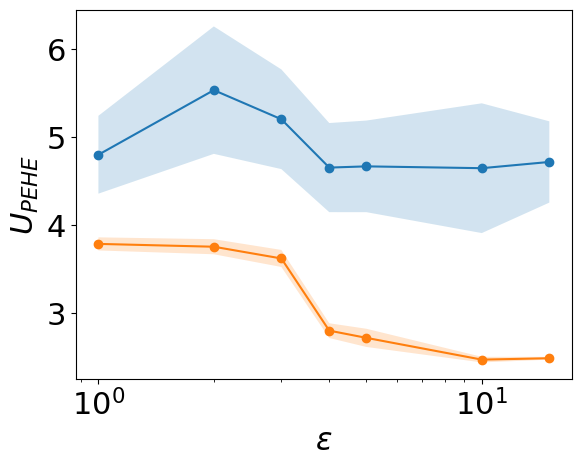

In [60]:
plt.plot(x, u_stand, 'o-', label = 'Standard')
plt.plot(x, u_seq, 'o-', label = 'Sequential')
plt.fill_between(x, u_stand - u_stand_std, u_stand + u_stand_std, alpha=0.2)
plt.fill_between(x, u_seq - u_seq_std, u_seq + u_seq_std, alpha=0.2)
#plt.legend()
plt.ylabel('$U_{PEHE}$')
plt.xlabel('$\epsilon$')
plt.xscale('log')
plt.savefig('plots/U_with_epsilon.pdf', bbox_inches='tight')